<a href="https://colab.research.google.com/github/tsparaskevas/DataJournalism/blob/main/Final%20essay/Final_homework_for_EDDE2_(preprocess_and_analysis)_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**1 ---- Download / Install packages**

1. Αρχικά κάνουμε εγκατάσταση (σβήνουμε το ```#``` και τρέχουμε το cell)
2. Μόλις εγκατασταθεί ξαναβάζουμε το ```#```
3. Κάνουμε Runtime > Restart runtime



**Greek (spacy)**

In [ ]:
#!python -m spacy download el_core_news_sm

###**2 ---- Import Libraries and Language (Greek)**

**Libraries**

In [ ]:
import pandas as pd
import numpy as np 

#from io import StringIO

from datetime import date
from datetime import datetime

import os
from pathlib import Path

import glob

import re

import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

%matplotlib inline

from PIL import Image

from google.colab import drive 
drive.mount('gdrive', force_remount=True)

from wordcloud import WordCloud, STOPWORDS

import spacy

from sklearn.feature_extraction.text import CountVectorizer

Mounted at gdrive


**Languages**

Greek

In [ ]:
gr_nlp = spacy.load('el_core_news_sm')
gr_stopwords = gr_nlp.Defaults.stop_words
print("Number of greek stopwords:", len(gr_stopwords))

Number of greek stopwords: 663


###**3 ---- Define paths and vars**

**Define paths**

Τα csv για processing είναι στο φάκελο Processing

In [ ]:
# main drive path
drive_path = "gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/Processing/"
# path to look for csv files
path = r"gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/Processing/*.csv"
# csvs sub names and suffixes to be removed
csv_suf1 = "_2020.csv" # tweets
csv_suf2 = "_all.csv" # websites
csv_sub1 = "_full_articles" # websites

###**4 ---- Setup and Pre-Preprocessing**

**Maximize colwidth display**

In [ ]:
# Μεγιστοποίηση του πλάτους της στήλης για εμφάνιση ολόκληρου του κειμένου
#pd.set_option('display.max_colwidth', None)

**Create dfs and put theme in dictionaries (websites, tweets)**

In [ ]:
# store paths_to_csvs in a list
csv_pathsL = glob.glob(path, recursive=True)

# make dfs from csvs and store them in a dictionary with key names the names of the csvs
dfs_websites_full_csvs_dict = {}
dfs_tweets_full_csvs_dict = {}
for i in csv_pathsL:
  key = i.replace(drive_path, "").replace(csv_suf1, "").replace(csv_suf2, "").replace(csv_sub1, "")
  value = pd.read_csv(i)
  if "tweets" in key:
    dfs_tweets_full_csvs_dict[key] = value
  else:
    dfs_websites_full_csvs_dict[key] = value

In [ ]:
# check websites' dictionary keys and dfs' column names
print(list(dfs_websites_full_csvs_dict.keys()))
print(list(dfs_websites_full_csvs_dict[list(dfs_websites_full_csvs_dict.keys())[0]].columns))

['lifo_dolofonia', 'lifo_syzygoktonia', 'dikaiologitika_dolofonia', 'dikaiologitika_anthropoktonia', 'cnn_dolofonia', 'lifo_anthropoktonia', 'cnn_anthropoktonia', 'naftemporiki_anthropoktonia', 'naftemporiki_dolofonia', 'naftemporiki_gynaikoktonia', 'newsbomb_anthropoktonia', 'newsbomb_dolofonia', 'newsit_dolofonia', 'cnn_ergatiko', 'dikaiologitika_ergatiko', 'naftemporiki_ergatiko', 'newsit_ergatiko', 'newsbomb_ergatiko', 'cnn_suicide', 'dikaiologitika_suicide', 'naftemporiki_suicide', 'lifo_suicide', 'newsit_suicide', 'newsbomb_suicide', 'cnn_troxaio', 'dikaiologitika_troxaio', 'lifo_troxaio', 'naftemporiki_troxaio', 'newsit_troxaio', 'newsbomb_troxaio', 'lifo_ergatiko', 'newsit_anthropoktonia']
['Title', 'Url', 'Lead', 'Section', 'Date', 'Author', 'Text']


In [ ]:
# check tweets' dictionary keys and dfs' column names
print(list(dfs_tweets_full_csvs_dict.keys()))
print(list(dfs_tweets_full_csvs_dict[list(dfs_tweets_full_csvs_dict.keys())[0]].columns))

['tweets_troxaio', 'tweets_ergatiko', 'tweets_suicide', 'tweets_homocide']
['author id', 'created_at', 'geo', 'id', 'lang', 'like_count', 'quote_count', 'reply_count', 'retweet_count', 'source', 'tweet']


In [ ]:
# check the datetime format in websites
print("websites's date format:", dfs_websites_full_csvs_dict[list(dfs_websites_full_csvs_dict.keys())[0]].loc[0, "Date"])
# check the datetime format in tweets
print("tweets's date format:", dfs_tweets_full_csvs_dict[list(dfs_tweets_full_csvs_dict.keys())[0]].loc[0, "created_at"])

websites's date format: 2021-01-02 15:19:00
tweets's date format: 2020-01-30 22:45:51+00:00


**Copy dfs dictionaries to work with**

In [ ]:
# make a copy of the websites' dfs dictionary
dfs_websites_short_csvs_dict = dfs_websites_full_csvs_dict.copy()
# make a copy of the tweets' dfs dictionary
dfs_tweets_short_csvs_dict = dfs_tweets_full_csvs_dict.copy()

**Remove bad structured tweets, remove full_text duplicates, convert to datetime, keep only "datetime" and "full_text" columns, make "name" column**

In [ ]:
# look for duplicates
#duplicate_in_tweet_text = dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[0]].duplicated(subset=['tweet'])
#if duplicate_in_tweet_text.any():
#    print(dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[0]].loc[duplicate_in_tweet_text].index)

Tweets

In [ ]:
for i in range(0, len(list(dfs_tweets_full_csvs_dict.keys()))):
  # keep only rows if 'id' is numeric (sometimes tweets data are distorted in columns)
  try:
    dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]] = dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]][dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]].id.apply(lambda x: x.isnumeric())]
  except:
    pass
  # remove rows if there are duplicates in 'tweet' column
  dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]].drop_duplicates(subset=['tweet'], inplace=True)
  # convert 'created_at' to datetime to a new column
  dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]]['datetime'] = pd.to_datetime(dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]]['created_at'], format='%Y-%m-%d %H:%M:%S+00:00')
  # keep only the "datetime" and "full_text" columns
  dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]] = dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]][['datetime', 'tweet']]
  # make a "Topic" column and assign the name of the key
  dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]] = dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]].assign(topic = list(dfs_tweets_short_csvs_dict.keys())[i])
  # reset index
  dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]].reset_index(drop=True, inplace=True)

Websites

In [ ]:
for i in range(0, len(list(dfs_websites_short_csvs_dict.keys()))):
  # remove rows if there are duplicates in 'Url' column
  dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]].drop_duplicates(subset=['Url'], inplace=True)
  # convert 'Date' to datetime to a new column
  dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]]['datetime'] = pd.to_datetime(dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]]['Date'], format='%Y-%m-%d %H:%M:%S')
  # keep only the "Datetime", "Title", "Lead" and "Text" columns
  dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]] = dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]][['datetime', 'Title', 'Lead', 'Text']]
  # make a "Topic" column and assign the name of the key
  dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]] = dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]].assign(topic = list(dfs_websites_short_csvs_dict.keys())[i])
  # reset index
  dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]].reset_index(drop=True, inplace=True)

**Merge dfs**

Tweets

In [ ]:
# merge tweets dfs
for i in range(0, len(list(dfs_tweets_full_csvs_dict.keys()))-1):
  if i == 0:
    tweets_df = pd.merge(dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i]], dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i+1]], how="outer", on=["datetime", "tweet", 'topic'])
  else:
    tweets_df = pd.merge(tweets_df, dfs_tweets_short_csvs_dict[list(dfs_tweets_short_csvs_dict.keys())[i+1]], how="outer", on=["datetime", "tweet", 'topic'])

# sort values by datetime
#comp_df.sort_values('datetime', ascending=False, inplace=True, ignore_index=True)

In [ ]:
# check unique values in 'Topic' column
tweets_df.topic.unique()

array(['tweets_troxaio', 'tweets_ergatiko', 'tweets_suicide',
       'tweets_homocide'], dtype=object)

Websites

In [ ]:
# merge websites dfs
for i in range(0, len(list(dfs_websites_short_csvs_dict.keys()))-1):
  if i == 0:
    websites_df = pd.merge(dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i]], dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i+1]], how="outer", on=["datetime", "Title", 'Lead', 'Text', 'topic'])
  else:
    websites_df = pd.merge(websites_df, dfs_websites_short_csvs_dict[list(dfs_websites_short_csvs_dict.keys())[i+1]], how="outer", on=["datetime", "Title", 'Lead', 'Text', 'topic'])

# sort values by datetime
#comp_df.sort_values('datetime', ascending=False, inplace=True, ignore_index=True)

In [ ]:
# check unique values in 'Topic' column
websites_df.topic.unique()

array(['lifo_dolofonia', 'lifo_syzygoktonia', 'dikaiologitika_dolofonia',
       'dikaiologitika_anthropoktonia', 'cnn_dolofonia',
       'lifo_anthropoktonia', 'cnn_anthropoktonia',
       'naftemporiki_anthropoktonia', 'naftemporiki_dolofonia',
       'naftemporiki_gynaikoktonia', 'newsbomb_anthropoktonia',
       'newsbomb_dolofonia', 'newsit_dolofonia', 'cnn_ergatiko',
       'dikaiologitika_ergatiko', 'naftemporiki_ergatiko',
       'newsit_ergatiko', 'newsbomb_ergatiko', 'cnn_suicide',
       'dikaiologitika_suicide', 'naftemporiki_suicide', 'lifo_suicide',
       'newsit_suicide', 'newsbomb_suicide', 'cnn_troxaio',
       'dikaiologitika_troxaio', 'lifo_troxaio', 'naftemporiki_troxaio',
       'newsit_troxaio', 'newsbomb_troxaio', 'lifo_ergatiko',
       'newsit_anthropoktonia'], dtype=object)

**Make 'Source' & 'SubTopics' columns / Change names**

Tweets

In [ ]:
# rename columns
tweets_df.rename(columns = {'tweet':'full_text'}, inplace = True)
# create 'Source' column and assign Topic's value removing topic's name
tweets_df = tweets_df.assign(source = "twitter")
# remove Source's name and '_' from Topic's value
tweets_df['topic'] = tweets_df['topic'] .str.replace(r'.*_', '', regex=True)
# check Source's unique values
print("source:", tweets_df['source'].unique())
# check Topic's unique values
print("topic:", tweets_df['topic'].unique())
# check SubTopic's unique values
# check dtypes
print(tweets_df.dtypes)
# check shape
print(tweets_df.shape)
# check df
tweets_df.head(1)

source: ['twitter']
topic: ['troxaio' 'ergatiko' 'suicide' 'homocide']
datetime     datetime64[ns]
full_text            object
topic                object
source               object
dtype: object
(101609, 4)


datetime                                          full_text  \
0 2020-01-30 22:45:51  Μεγαλυτερη μαλακια απ το "εμεις φτιαχνουμε  τη...   

     topic   source  
0  troxaio  twitter

Websites

In [ ]:
# create 'Source' column and assign Topic's value removing topic's name
websites_df['source'] = websites_df['topic'].str.replace(r'_.*', '', regex=True)
# remove Source's name and '_' from Topic's value
websites_df['sub_topic'] = websites_df['topic'] .str.replace(r'.*_', '', regex=True)
# fix SubTopic's values
websites_df['sub_topic'] = websites_df['sub_topic'].str.replace(r'ergatiko|troxaio|suicide', ' ', regex=True)
# fix Topic's values
websites_df['topic'] = websites_df['topic'].str.replace(".*_", "", regex=True).str.replace(r'dolofonia|anthropoktonia|syzygoktonia|gynaikoktonia', 'homocide', regex=True)
# check Source's unique values
print("source:", websites_df['source'].unique())
# check Topic's unique values
print("topic:", websites_df['topic'].unique())
# check SubTopic's unique values
print("sub_topic:", websites_df['sub_topic'].unique())
# check dtypes
print(websites_df.dtypes)
# check shape
print(websites_df.shape)
# check df
websites_df.head(1)

source: ['lifo' 'dikaiologitika' 'cnn' 'naftemporiki' 'newsbomb' 'newsit']
topic: ['homocide' 'ergatiko' 'suicide' 'troxaio']
sub_topic: ['dolofonia' 'syzygoktonia' 'anthropoktonia' 'gynaikoktonia' ' ']
datetime     datetime64[ns]
Title                object
Lead                 object
Text                 object
topic                object
source               object
sub_topic            object
dtype: object
(11022, 7)


datetime                                              Title  \
0 2021-01-02 15:19:00  Υπόθεση Γιαμπουράνη: Καταδίκη της Ελλάδας για ...   

                                                Lead  \
0  Στο Ευρωπαϊκό Δικαστήριο Ανθρωπίνων Δικαιωμάτω...   

                                                Text     topic source  \
0  Το Ευρωπαϊκό Δικαστήριο Ανθρωπίνων Δικαιωμάτων...  homocide   lifo   

   sub_topic  
0  dolofonia

**Concatenate text columns in websites_df**

In [ ]:
# fill nans
websites_df = websites_df.fillna(' ')
# join Title, Lead and Text
websites_df["full_text"] = websites_df["Title"] + websites_df["Lead"] + websites_df["Text"]
# preview df
websites_df.head()

datetime                                              Title  \
0 2021-01-02 15:19:00  Υπόθεση Γιαμπουράνη: Καταδίκη της Ελλάδας για ...   
1 2021-01-02 11:21:00  Η απρόβλεπτη κινηματογραφική συνεύρεση Νίκου Κ...   
2 2021-01-02 09:39:00  Οι «Μεταμορφώσεις» του Οβίδιου στο ελληνικό βι...   
3 2021-01-02 08:31:00  Το Ιράν αγνοεί τη συμφωνία για τα πυρηνικά και...   
4 2021-01-01 12:15:00  Ηλίας Μαζαράκης: Ο περιβόητος «εκτελεστής γιατ...   

                                                Lead  \
0  Στο Ευρωπαϊκό Δικαστήριο Ανθρωπίνων Δικαιωμάτω...   
1  Δύο μεγάλοι του κινηματογράφου, μαζί, σε μια β...   
2  Το εμβληματικό έργο του ρωμαίου ποιητή που πέθ...   
3  Ενημερώθηκε ο Διεθνής Οργανισμός Ατομικής Ενέρ...   
4  Η επιστολή και τα μυστικά της εξαφάνισής του -...   

                                                Text     topic source  \
0  Το Ευρωπαϊκό Δικαστήριο Ανθρωπίνων Δικαιωμάτων...  homocide   lifo   
1    ΤΟΣΟ Ο ΝΙΚΟΣ ΚΟΥΡΚΟΥΛΟΣ (1934-2007), όσο και...  homocide   lifo   
2                                                     homocide   lifo   
3  Το Ιράν έχει ενημερώσει τον παρατηρητή του ΟΗΕ...  homocide   lifo   
4  Νέα στοιχεία για τη ζωή του Ηλία Μαζαράκη, του...  homocide   lifo   

   sub_topic                                          full_text  
0  dolofonia  Υπόθεση Γιαμπουράνη: Καταδίκη της Ελλάδας για ...  
1  dolofonia  Η απρόβλεπτη κινηματογραφική συνεύρεση Νίκου Κ...  
2  dolofonia  Οι «Μεταμορφώσεις» του Οβίδιου στο ελληνικό βι...  
3  dolofonia  Το Ιράν αγνοεί τη συμφωνία για τα πυρηνικά και...  
4  dolofonia  Ηλίας Μαζαράκης: Ο περιβόητος «εκτελεστής γιατ...

**Drop 'Title', 'Lead' & 'Text' columns in websites_df**

In [ ]:
websites_df.drop(['Title', 'Lead', 'Text'], axis = 1, inplace = True)

**Merge tweets and websites dataframes**

In [ ]:
# merge dfs
comp_df = pd.merge(websites_df, tweets_df, how="outer", on=["datetime", "full_text", 'source', 'topic'])
# fill nans in sub_topic column
comp_df['sub_topic'].fillna(' ', inplace=True)

In [ ]:
# print information
print("comp_df shape:", comp_df.shape)
print("\r")
print("column names:", list(comp_df.columns.unique()))
print("\r")
print(comp_df.dtypes)
print("\r")
print("source values:", comp_df.source.unique())
print("\r")
print("topic values:", comp_df.topic.unique())
print("\r")
print("sub-topic values:", comp_df.sub_topic.unique())
print("\r")
print("nan values:", comp_df.isnull().values.any())

comp_df shape: (112631, 5)

column names: ['datetime', 'topic', 'source', 'sub_topic', 'full_text']

datetime     datetime64[ns]
topic                object
source               object
sub_topic            object
full_text            object
dtype: object

source values: ['lifo' 'dikaiologitika' 'cnn' 'naftemporiki' 'newsbomb' 'newsit'
 'twitter']

topic values: ['homocide' 'ergatiko' 'suicide' 'troxaio']

sub-topic values: ['dolofonia' 'anthropoktonia' 'syzygoktonia' 'gynaikoktonia' ' ']

nan values: True


**Delete rows that datetime is out of 2020**

In [ ]:
# old shape
print("old shape:", comp_df.shape)
# keep 2020 only
comp_df = comp_df[comp_df['datetime'].dt.year == 2020]
# sort values by datetime
comp_df = comp_df.sort_values('datetime', ascending=True)
# reset index
comp_df.reset_index(drop=True, inplace=True)
# new shape
print("new shape:", comp_df.shape)

old shape: (112631, 5)
new shape: (112123, 5)


**Preview comp_df**

In [ ]:
comp_df

datetime     topic    source       sub_topic  \
0      2020-01-01 00:32:59  homocide   twitter                   
1      2020-01-01 01:04:06   troxaio   twitter                   
2      2020-01-01 01:23:01  homocide   twitter                   
3      2020-01-01 02:34:59   troxaio   twitter                   
4      2020-01-01 02:43:23   troxaio   twitter                   
...                    ...       ...       ...             ...   
112118 2020-12-31 15:11:00  homocide      lifo       dolofonia   
112119 2020-12-31 17:57:00   troxaio  newsbomb                   
112120 2020-12-31 18:31:00  homocide      lifo  anthropoktonia   
112121 2020-12-31 19:54:00   troxaio  newsbomb                   
112122 2020-12-31 22:22:05   troxaio    newsit                   

                                                full_text  
0       @Toshir0_Mifune @kentrodexia @v_agras @nicolao...  
1       ΤΩΡΑ: Τροχαίο ατύχημα με το «καλημέρα» του 202...  
2       «Δολοφόνος» στο πίσω κάθισμα – Ένα δυσάρεστο μ...  
3       Πέτρος Συρίγος: Τροχαίο με τη μηχανή του είχε ...  
4       Φρικτό τροχαίο στη Νέα Ιωνία: 25χρονη αστυνομι...  
...                                                   ...  
112118  Βίλια: Νέα στοιχεία για το πτώμα στη βαλίτσα -...  
112119  Νέα τραγωδία στην Κύπρο: Νεκρός 35χρονος μοτοσ...  
112120  Βίλια: Σε 38χρονη Κινέζα το πτώμα που βρέθηκε ...  
112121  Πεντέλη: Λιμουζίνα πήρε τον κατήφορο και έπεσε...  
112122  Αλγερία: 20 νεκροί από τροχαίο δυστύχημα 20 άν...  

[112123 rows x 5 columns]

###**5 ---- Cleaning**

**Cleaning**

In [ ]:
# Μεγιστοποίηση του πλάτους της στήλης για εμφάνιση ολόκληρου του κειμένου
# pd.set_option('display.max_colwidth', None)

# Reset display options
#pd.reset_option("all")

In [ ]:
# Remove τόνους και διαλυτικά
#comp_df['clean_text'] = comp_df['full_text'].str.replace(r'[άΆ]','α', regex=True).str.replace(r"[έΈ]", "ε", regex=True).str.replace(r'[ήΉ]','η', regex=True).str.replace(r'[ίΊϊΪ]','ι', regex=True).str.replace(r'[όΌ]','ο', regex=True).str.replace(r'[ύΎϋΫ]','υ', regex=True).str.replace(r'[ώΏ]','ω', regex=True)
# Remove urls, hashtags and mentions
comp_df['clean_text'] = comp_df['full_text'].str.replace(r'@[A-Za-zΑ-Ωα-ω0-9ΆάΈέΊίΪϊΉήΌόΎύΫϋΏώ_]+', '', regex=True).str.replace(r'#[A-Za-zΑ-Ωα-ω0-9ΆάΈέΊίΪϊΉήΌόΎύΫϋΏώ_]+', '', regex=True).str.replace(r'https?://[^ ]+', '', regex=True).str.replace(r'www.[^ ]+', '', regex=True).str.lower()
# Remove panctuation
comp_df['clean_text'] = comp_df['clean_text'].str.replace(r'[\n\…\.\:\'\'\-\"\“\”\«\»\–\–\(\)]', " ", regex=True).str.replace(r'&gt;|s&amp;p|\samp\s', ' ', regex=True)#.str.replace('  ', ' ')
# Keep only letters 
comp_df['clean_text'] = comp_df['clean_text'].str.replace(r'[^a-zA-Zα-ωΑ-Ω0-9ΆάΈέΊίΪϊΉήΌόΎύΫϋΏώ ]', ' ', regex=True).str.replace('  ', ' ')
comp_df['clean_text'] = comp_df['clean_text'].str.replace(r'δείτε όλες τις τελευταίες ειδήσεις .*', '', regex=True)

In [ ]:
# Check cleaning results
comp_df[['full_text', 'clean_text']].loc[111982:111991]

full_text  \
111982  Οδηγούσε μεθυσμένος και συνελήφθη μετά από τρο...   
111983  Κύπρια παρουσιάστρια σκοτώθηκε σε τροχαίο (ΕΙΚ...   
111984  eXofitsio: Δολοφονία Τοπαλούδη: Προκαταρκτική ...   
111985                    @aeisixtir Αυτοκτονία χαρακτήρα   
111986  @AdonisGeorgiadi @g_evgenidis Αυτό δεν λέγεται...   
111987  ρε άντε γαμηθείτε που υπερασπίζεστε τον #Χατζη...   
111988  Τα 7 εγκλήματα που πάγωσαν την Κρήτη και συντά...   
111989  Τα 7 εγκλήματα που πάγωσαν την Κρήτη και συντά...   
111990  Οι 45 που έγιναν 125Σήμερα: Ο Καρντέν σχεδίασε...   
111991  Ένα γεγονός + ένα βιβλίο\nΣαν σήμερα 20 Δεκεμβ...   

                                               clean_text  
111982  οδηγούσε μεθυσμένος και συνελήφθη μετά από τρο...  
111983  κύπρια παρουσιάστρια σκοτώθηκε σε τροχαίο εικο...  
111984  exofitsio δολοφονία τοπαλούδη προκαταρκτική έρ...  
111985                               αυτοκτονία χαρακτήρα  
111986   αυτό δεν λέγεται δολοφονία χαρακτήρα λέγεται ...  
111987  ρε άντε γαμηθείτε που υπερασπίζεστε τον που κα...  
111988  τα 7 εγκλήματα που πάγωσαν την κρήτη και συντά...  
111989  τα 7 εγκλήματα που πάγωσαν την κρήτη και συντά...  
111990  οι 45 που έγιναν 125σήμερα ο καρντέν σχεδίασε ...  
111991  ένα γεγονός  ένα βιβλίο σαν σήμερα 20 δεκεμβρί...

**Continue**

In [ ]:
# create one column with gr_text and turkish translated text
#comp_df['text'] = comp_df[['gr_text', 'clean_translated_text']].apply(lambda x: x.str.cat(sep=''), axis=1)

In [ ]:
# Remove τόνους και διαλυτικά in text
#comp_df['text'] = comp_df['text'].str.replace(r'[άΆ]','α', regex=True).str.replace(r"[έΈ]", "ε", regex=True).str.replace(r'[ήΉ]','η', regex=True).str.replace(r'[ίΊϊΪ]','ι', regex=True).str.replace(r'[όΌ]','ο', regex=True).str.replace(r'[ύΎϋΫ]','υ', regex=True).str.replace(r'[ώΏ]','ω', regex=True)


In [ ]:
# preview df
comp_df.loc[3986:3987]

datetime     topic   source sub_topic  \
3986 2020-01-07 19:57:02  homocide  twitter             
3987 2020-01-07 19:57:30  homocide  twitter             

                                              full_text  \
3986  Ίσως το καλύτερο ντοκυμαντέρ για την δολοφονία...   
3987  Η δολοφονία που ένωσε τον Ιρανικό λαό και ο φό...   

                                             clean_text  
3986  ίσως το καλύτερο ντοκυμαντέρ για την δολοφονία...  
3987  η δολοφονία που ένωσε τον ιρανικό λαό και ο φό...

In [ ]:
# check for any nan values in 'clean_text' & 'text'
comp_df[['full_text', 'clean_text']].isnull().sum()

full_text     0
clean_text    0
dtype: int64

###**6 ---- Tables and Graphs about the research's ID and content stats**

In [ ]:
# Make a copy of the comp_df to change the labels of the topic
comp_stats_df = comp_df.copy(deep=True)
comp_stats_df['topic'] = comp_stats_df['topic'].str.replace('ergatiko', 'εργατικό ατύχημα').str.replace('homocide', 'ανθρωποκτονία').str.replace('suicide', 'αυτοκτονία').str.replace('troxaio', 'τροχαίο')
comp_stats_df.head(1)

datetime          topic   source sub_topic  \
0 2020-01-01 00:32:59  ανθρωποκτονία  twitter             

                                           full_text  \
0  @Toshir0_Mifune @kentrodexia @v_agras @nicolao...   

                                          clean_text  
0     άρα να ποινικοποιήσουμε και τη δολοφονία το...

**Create research's content info dataframe**

In [ ]:
# column names
column_names = ["Πηγή", "Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό ατύχημα", "Τροχαίο", "Σύνολο"]
# create df
id_df = pd.DataFrame(columns = column_names)
# preview df
id_df

Empty DataFrame
Columns: [Πηγή, Ανθρωποκτονία, Αυτοκτονία, Εργατικό ατύχημα, Τροχαίο, Σύνολο]
Index: []

In [ ]:
# list with source's names
sourceL = ['cnn.gr', 'dikaiologitika.gr', 'lifo.gr', 'naftemporiki.gr', 'newsbomb.gr', 'newsit.gr', 'twitter']
for i in range(0, len(sourceL)):
  if sourceL[i] == 'twitter':
    source_name = sourceL[i]
  else:
    source_name = sourceL[i][:-3]
  homo = comp_stats_df.loc[(comp_stats_df.topic == 'ανθρωποκτονία') & (comp_stats_df.source == source_name), 'clean_text'].size
  sui = comp_stats_df.loc[(comp_stats_df.topic == 'αυτοκτονία') & (comp_stats_df.source == source_name), 'clean_text'].size
  erg = comp_stats_df.loc[(comp_stats_df.topic == 'εργατικό ατύχημα') & (comp_stats_df.source == source_name), 'clean_text'].size
  tro = comp_stats_df.loc[(comp_stats_df.topic == 'τροχαίο') & (comp_stats_df.source == source_name), 'clean_text'].size
  syn = homo + sui + erg + tro
  id_df.loc[i] = [sourceL[i], homo, sui, erg, tro, syn]

# add Total sum per column: 
id_df.loc[7, 'Πηγή'] = 'Σύνολο κειμένων'
id_df.loc[7, 'Ανθρωποκτονία':]= id_df[['Ανθρωποκτονία', 'Αυτοκτονία', 'Εργατικό ατύχημα', 'Τροχαίο', 'Σύνολο']].sum(axis=0)

# add Total sum per row: 
#id_df.loc[:,'Σύνολο'] = id_df.sum(axis=1)

id_df

Πηγή Ανθρωποκτονία Αυτοκτονία Εργατικό ατύχημα Τροχαίο  Σύνολο
0             cnn.gr           816         69                7     225    1117
1  dikaiologitika.gr           937        110               43     400    1490
2            lifo.gr          1719        339               16     353    2427
3    naftemporiki.gr           333        121               15     534    1003
4        newsbomb.gr           845        164               26     844    1879
5          newsit.gr          1524        168               10     898    2600
6            twitter         57864       6484             1513   35746  101607
7    Σύνολο κειμένων         64038       7455             1630   39000  112123

In [ ]:
# make table from dataframe
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

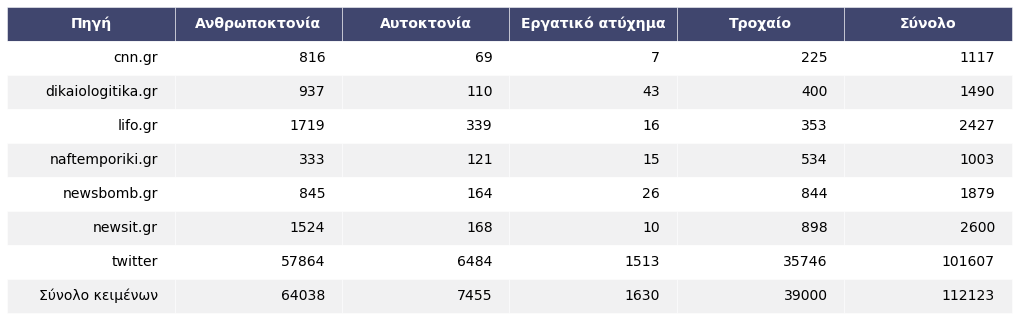

In [ ]:
# render table
render_mpl_table(id_df, header_columns=0, col_width=3)

**Graphs from texts data**

**# of articles per topic, per website**

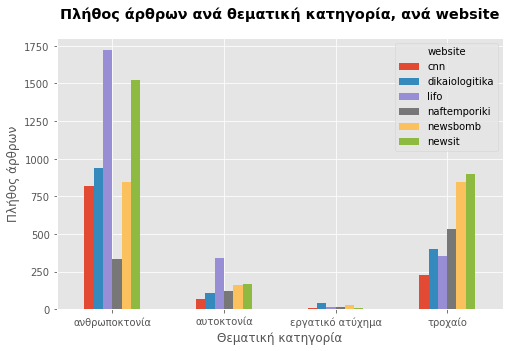

In [ ]:
stats = comp_stats_df[comp_stats_df.source != 'twitter'].groupby(['topic', 'source']).count()['clean_text']
# plot the result
stats.unstack().plot(kind='bar', figsize=(8,5))
plt.title('Πλήθος άρθρων ανά θεματική κατηγορία, ανά website', y=1.05, fontweight='bold')
plt.xlabel('Θεματική κατηγορία')
plt.ylabel('Πλήθος άρθρων')
plt.xticks(rotation=0)
legend = plt.legend(title="website")   #(handles=[one, two, three], title="title", loc=4, fontsize='small', fancybox=True)
plt.show()

**# of articles per topic in all websites**

In [ ]:
#!pip install cutecharts

In [ ]:
#import library and data
#import cutecharts.charts as ctc

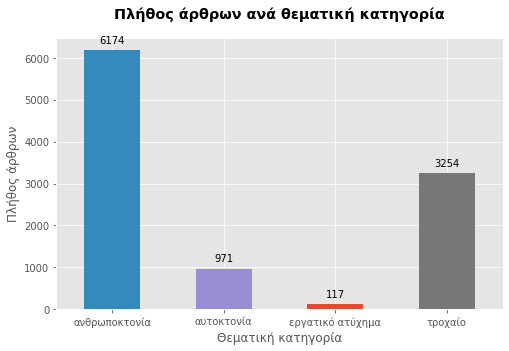

In [ ]:
stats = comp_stats_df[comp_stats_df.source != 'twitter'].groupby('topic').count()['clean_text']

# plot the result
ax=stats.plot(kind='bar', figsize=(8,5), color = ['#348ABD', '#988ED5', '#E24A33', '#777777'])
plt.title('Πλήθος άρθρων ανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xlabel('Θεματική κατηγορία')
plt.ylabel('Πλήθος άρθρων')
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(s=np.round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

**# of tweets per topic in twitter**

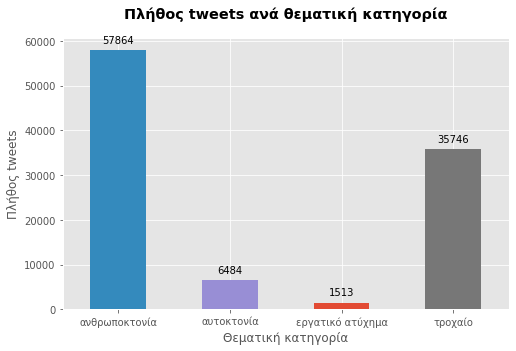

In [ ]:
stats = comp_stats_df[comp_stats_df.source == 'twitter'].groupby('topic').count()['clean_text']

# plot the result
ax=stats.plot(kind='bar', figsize=(8,5), color = ['#348ABD', '#988ED5', '#E24A33', '#777777']) #color=(0.2, 0.4, 0.6, 1))
plt.title('Πλήθος tweets ανά θεματική κατηγορία', y=1.05, fontweight='bold')
plt.xlabel('Θεματική κατηγορία')
plt.ylabel('Πλήθος tweets')
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(s=np.round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

In [ ]:
#stats.plot.pie(subplots=True, figsize=(10, 3))

**CNN - % of articles per topic**

In [ ]:
cnn = comp_df[comp_df.source == 'cnn'].groupby('topic')['clean_text'].count()

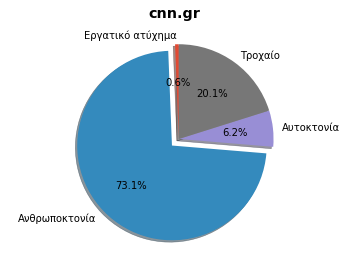

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(cnn, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('cnn.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**DIKAIOLOGITIKA - % of articles per topic**

In [ ]:
dikaiologitika = comp_df[comp_df.source == 'dikaiologitika'].groupby('topic')['clean_text'].count()

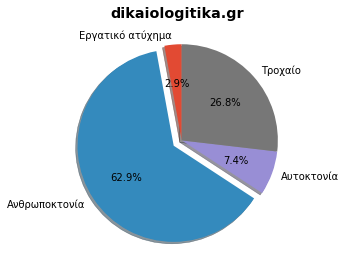

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(dikaiologitika, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('dikaiologitika.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**LIFO - % of articles per topic**

In [ ]:
lifo = comp_df[comp_df.source == 'lifo'].groupby('topic')['clean_text'].count()

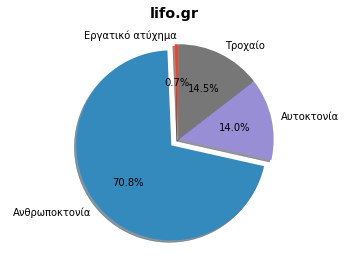

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(lifo, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('lifo.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**NAFTEMPORIKI - % of articles per topic**

In [ ]:
naftemporiki = comp_df[comp_df.source == 'naftemporiki'].groupby('topic')['clean_text'].count()

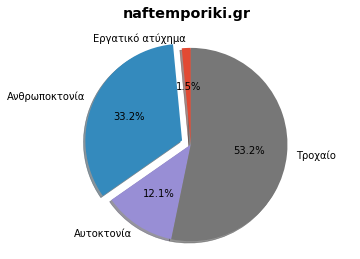

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(naftemporiki, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('naftemporiki.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**NEWSBOMB - % of articles per topic**

In [ ]:
newsbomb = comp_df[comp_df.source == 'newsbomb'].groupby('topic')['clean_text'].count()

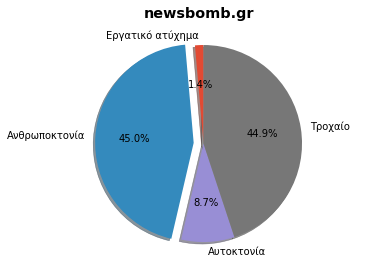

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(newsbomb, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('newsbomb.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**NEWSIT - % of articles per topic**

In [ ]:
newsit = comp_df[comp_df.source == 'newsit'].groupby('topic')['clean_text'].count()

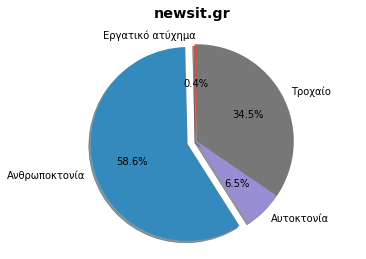

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(newsit, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('newsit.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

**TWITTER - % of tweets per topic**

In [ ]:
twitter = comp_df[comp_df.source == 'twitter'].groupby('topic')['clean_text'].count()

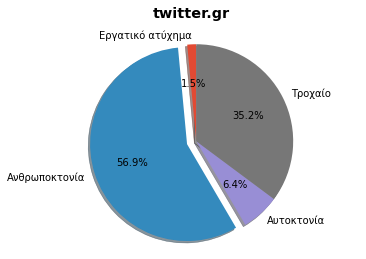

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(twitter, labels=label, autopct='%1.1f%%', explode=[0,0.1,0,0], shadow=True, startangle=90)
plt.title('twitter.gr', y=1.05, fontweight='bold')
plt.axis('equal')
plt.show()

###**7 ---- Tables and Graphs from Police statistics**

In [ ]:
# import csv as dataframe
police_stats_df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/statistics2020.csv")
police_stats_df

Unnamed: 0  troxaio  troxaio-dead  ergatiko  Ergatiko-dead  suicide  \
0    Jan 2020      804            46       173              4      122   
1    Feb 2020      887            46       128              3      103   
2    Mar 2020      520            22       100              2       87   
3    Apr 2020      339            21       108              2       88   
4    May 2020      747            52       142              3       92   
5    Jun 2020      922            49       144              8      100   
6    Jul 2020     1017            48       151              5      105   
7    Aug 2020      903            58       149              6      111   
8    Sep 2020     1032            63       202              6       90   
9    Oct 2020      967            67       151              8       79   
10   Noe 2020      673            49       171              5       52   
11   Dec 2020      570            29       139              6       90   
12   Sum 2020     9381           550      1758             58     1117   

    Suicide-dead  homocide  Homocide-dead  
0             43        33             12  
1             35        22              7  
2             40        18              6  
3             33        15              6  
4             41        24             12  
5             40        34             19  
6             48        28             12  
7             41        31             11  
8             39        10              4  
9             37        29             19  
10            22        18              9  
11            33        19             13  
12           451       281            130

In [ ]:
# rename Unamed: 0 column to date
police_stats_df.rename(columns = {'Unnamed: 0':'date'}, inplace = True) 

**Create police's content info dataframe & image table**

In [ ]:
# column names
pol_column_names = [" ", "Ανθρωποκτονία", "Αυτοκτονία", "Εργατικό ατύχημα", "Τροχαίο", "Σύνολο"]
# create df
pol_id_df = pd.DataFrame(columns = pol_column_names)
# preview df
pol_id_df

Empty DataFrame
Columns: [ , Ανθρωποκτονία, Αυτοκτονία, Εργατικό ατύχημα, Τροχαίο, Σύνολο]
Index: []

In [ ]:
# list with source's names
incidentsL = ['homocide', 'suicide', 'ergatiko', 'troxaio']
deadL = ['Homocide-dead', 'Suicide-dead', 'Ergatiko-dead', 'troxaio-dead']
homo = police_stats_df.loc[12, incidentsL[0]]
homo_dead = police_stats_df.loc[12, deadL[0]]
sui = police_stats_df.loc[12, incidentsL[1]]
sui_dead = police_stats_df.loc[12, deadL[1]]
erg = police_stats_df.loc[12, incidentsL[2]]
erg_dead = police_stats_df.loc[12, deadL[2]]
tro = police_stats_df.loc[12, incidentsL[3]]
tro_dead = police_stats_df.loc[12, deadL[3]]
syn_inc = homo + sui + erg + tro
syn_dead = homo_dead + sui_dead + erg_dead + tro_dead
pol_id_df.loc[0, ' '] = "Συμβάντα"
pol_id_df.loc[0, 'Ανθρωποκτονία':] = [homo, sui, erg, tro, syn_inc]
pol_id_df.loc[1, ' '] = "Νεκροί"
pol_id_df.loc[1, 'Ανθρωποκτονία':] = [homo_dead, sui_dead, erg_dead, tro_dead, syn_dead]

# add Total sum per column: 
#id_df.loc[7, 'Πηγή'] = 'Σύνολο κειμένων'
#id_df.loc[7, 'Ανθρωποκτονία':]= id_df[['Ανθρωποκτονία', 'Αυτοκτονία', 'Εργατικό ατύχημα', 'Τροχαίο', 'Σύνολο']].sum(axis=0)

# add Total sum per row: 
#id_df.loc[:,'Σύνολο'] = id_df.sum(axis=1)

pol_id_df

Ανθρωποκτονία Αυτοκτονία Εργατικό ατύχημα Τροχαίο Σύνολο
0  Συμβάντα           281       1117             1758    9381  12537
1    Νεκροί           130        451               58     550   1189

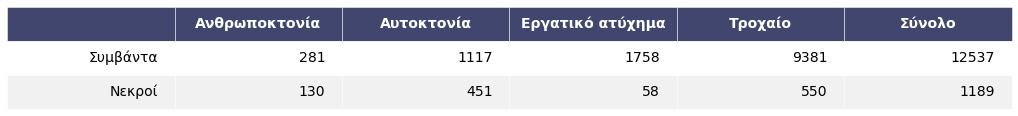

In [ ]:
# render table
render_mpl_table(pol_id_df, header_columns=0, col_width=3)

**Graphs from Police data**

In [ ]:
# rename columns
police_stats_gr_df = police_stats_df.rename(columns = {'troxaio':'τροχαίο', 'troxaio-dead':'Τροχαίο', 'ergatiko':'εργατικό ατύχημα', 'Ergatiko-dead':'Εργατικό ατύχημα', 'suicide':'αυτοκτονία', 'Suicide-dead':'Αυτοκτονία', 'homocide':'ανθρωποκτονία', 'Homocide-dead':'Ανθρωποκτονία'})

**# of incidents per category from police stats**

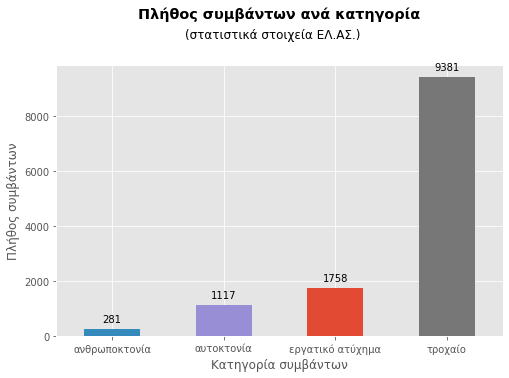

In [ ]:
incidents_nbr = police_stats_gr_df.loc[[12]][['ανθρωποκτονία', 'αυτοκτονία', 'εργατικό ατύχημα', 'τροχαίο']].T

# plot the result
ax=incidents_nbr[12].plot(kind='bar', figsize=(8,5), color = ['#348ABD', '#988ED5', '#E24A33', '#777777'], legend=None) 
plt.title('Πλήθος συμβάντων ανά κατηγορία', y=1.15, fontweight='bold')
plt.suptitle('(στατιστικά στοιχεία ΕΛ.ΑΣ.)')
plt.xlabel('Κατηγορία συμβάντων')
plt.ylabel('Πλήθος συμβάντων')
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(s=np.round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

**# of dead per category from police stats**

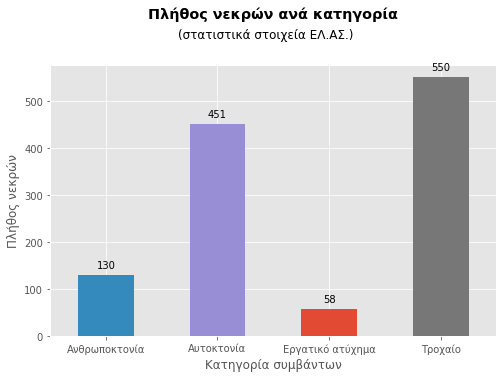

In [ ]:
dead_nbr = police_stats_gr_df.loc[[12]][['Ανθρωποκτονία', 'Αυτοκτονία', 'Εργατικό ατύχημα', 'Τροχαίο']].T

# plot the result
ax=dead_nbr[12].plot(kind='bar', figsize=(8,5), color = ['#348ABD', '#988ED5', '#E24A33', '#777777'], legend=None) 
plt.title('Πλήθος νεκρών ανά κατηγορία', y=1.15, fontweight='bold')
plt.suptitle('(στατιστικά στοιχεία ΕΛ.ΑΣ.)')
plt.xlabel('Κατηγορία συμβάντων')
plt.ylabel('Πλήθος νεκρών')
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(s=np.round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')
plt.show()

**POLICE STATS - % of incidents per topic**

In [ ]:
incidents = police_stats_df.loc[[12]][['ergatiko', 'homocide', 'suicide','troxaio']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


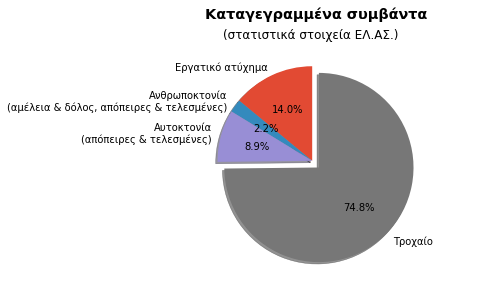

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία\n(αμέλεια & δόλος, απόπειρες & τελεσμένες)', 'Αυτοκτονία\n(απόπειρες & τελεσμένες)', 'Τροχαίο']
plt.pie(incidents, labels=label, autopct='%1.1f%%', explode=[0,0,0,0.1], shadow=True, startangle=90)
plt.title('Καταγεγραμμένα συμβάντα', y=1.15, fontweight='bold')
plt.suptitle('(στατιστικά στοιχεία ΕΛ.ΑΣ.)')
plt.axis('equal')
plt.show()

**POLICE STATS - % of dead per topic**

In [ ]:
dead = police_stats_df.loc[[12]][['Ergatiko-dead', 'Homocide-dead', 'Suicide-dead','troxaio-dead']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


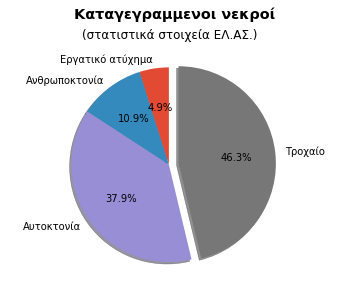

In [ ]:
label = ['Εργατικό ατύχημα', 'Ανθρωποκτονία', 'Αυτοκτονία', 'Τροχαίο']
plt.pie(dead, labels=label, autopct='%1.1f%%', explode=[0,0,0,0.1], shadow=True, startangle=90)
plt.title('Καταγεγραμμενοι νεκροί', y=1.15, fontweight='bold')
plt.suptitle('(στατιστικά στοιχεία ΕΛ.ΑΣ.)')
plt.axis('equal')
plt.show()

###**8 ---- Vectorization**

In [ ]:
# Vectorizer
cv = CountVectorizer(stop_words= gr_stopwords, max_features=20, ngram_range=(2, 2))

In [ ]:
# cleaning after previewing the results
# remove search keywords
comp_df['clean_text_new'] = comp_df['clean_text'].str.replace(r'αυτοκτ[οό]ν[ησείια]+|δολοφ[όο]ν[ιίαος]+|ανθρωποκτονία|τροχαίο|εργατικ[οό][υύ]? ατ[υύ]χ[ηή]μα[τος]*', ' ', regex=True)
# remove read more etc
comp_df['clean_text_new'] = comp_df['clean_text_new'].str.replace(r'διαβ[άα]στε|πατωντας| εδω | αρθρο |loadposition| gr |σήμερα|ειναι| απο | κι | οτι | αλλα | αυτο |amp', ' ', regex=True)
# correct death, χρυσή αυγή
comp_df['clean_text_new'] = comp_df['clean_text_new'].str.replace(r'θάνατος?', 'θάνατος', regex=True).str.replace(r'χρυσής?', 'χρυσή', regex=True).str.replace(r'αυγής?', 'αυγή', regex=True)
# correct more
comp_df['clean_text_new'] = comp_df['clean_text_new'].str.replace(r'ψυχικής?', 'ψυχική', regex=True).str.replace(r'υγείας?', 'υγεία', regex=True)
# correct more
comp_df['clean_text_new'] = comp_df['clean_text_new'].str.replace(r'νέας?', 'νέα', regex=True).str.replace(r'υόρκης?', 'υόρκη', regex=True)
# remove more stuff
comp_df['clean_text_new'] = comp_df['clean_text_new'].str.replace(r' pic | twitter | com | ευρώ |facebooktwitter| social media |47 ', ' ', regex=True)

In [ ]:
# save comp_df to csv
#comp_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/comp_df.csv", index=False)

In [ ]:
# check csv
#comp_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/comp_df.csv")

####**All Websites**

**Ανθρωποκτονία**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'])
w_homocide_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
w_homocide_results.head(1)

απε μπε  απόφαση δικαστηρίου  αστυνομικό τμήμα  δίκη χρυσή  \
0        0                    0                 0           0   

   εγκληματική οργάνωση  εγκληματικής οργάνωσης  ελένης τοπαλούδη  \
0                     0                       0                 0   

   ισόβια κάθειρξη  κασέμ σουλεϊμανί  μέση ανατολή  μικτό ορκωτό  νέα υόρκη  \
0                0                 0             0             0          0   

   ντόναλντ τραμπ  ορκωτό δικαστήριο  παύλου φύσσα  πληροφορίες απε  \
0               0                  0             0                0   

   πολιτικής αγωγής  σύμφωνα πληροφορίες  τζορτζ φλόιντ  χρυσή αυγή  
0                 0                    0              0           0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

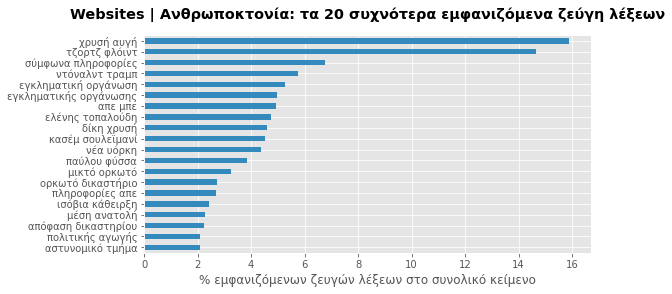

In [ ]:
w_homocide_words =  w_homocide_results.sum(axis =0)
w_homocide_percent = w_homocide_words.sort_values(ascending = False).head(20) / w_homocide_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = w_homocide_percent.plot(kind='barh', figsize=(8,4), color = '#348ABD', xlabel='').invert_yaxis()
plt.title('Websites | Ανθρωποκτονία: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Αυτοκτονία**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'])
w_suicide_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
w_suicide_results.head(1)

covid 19  έβαλε τέλος  έπεσε κενό  απε μπε  απονενοημένο διάβημα  \
0         0            0           0        0                     0   

   βάλει τέλος  βρέθηκε κρεμασμένος  βρέθηκε νεκρή  βρέθηκε νεκρός  \
0            0                    0              0               0   

   κοινωνικής δικτύωσης  νέα υόρκη  νεκροψία νεκροτομή  προφήτη ηλία  \
0                     0          0                   0             0   

   σύμφωνα πληροφορίες  τέλος ζωή  τζένιφερ ντούλος  τοπική κοινωνία  \
0                    0          0                 0                0   

   φώτης ντούλος  ψυχική υγεία  ψυχολογικά προβλήματα  
0              0             0                      0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

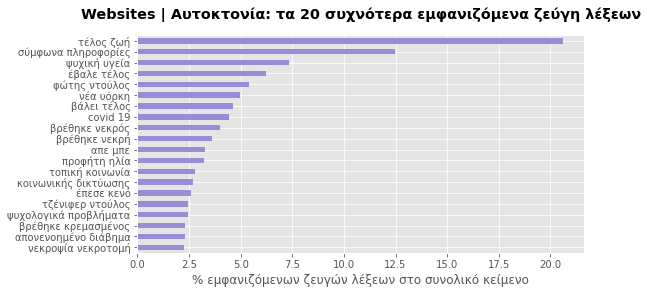

In [ ]:
w_suicide_words =  w_suicide_results.sum(axis =0)
w_suicide_percent = w_suicide_words.sort_values(ascending = False).head(20) / w_suicide_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = w_suicide_percent.plot(kind='barh', figsize=(8,4), color = '#988ED5', xlabel='').invert_yaxis()
plt.title('Websites | Αυτοκτονία: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Εργατικό ατύχημα**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'])
w_ergatiko_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
w_ergatiko_results.head(1)

covid 19  αποκατάστασης βλαβών  ασφαλιστικές εισφορές  δικτυακό τόπο  \
0         0                     0                      0              0   

   εγκαταστάσεις εργοδότη  εκ περιτροπής  εκτέλεση εργασιών  \
0                       0              0                  0   

   εργασίας κοινωνικών  εργοδότης υποχρεούται  ηλεκτρονικής συνταγογράφησης  \
0                    0                      0                             0   

   καλύπτει εργοδότης  κοινωνικής ασφάλισης  κοινωνικών υποθέσεων  \
0                   0                     0                     0   

   συμφωνία τηλεργασίας  συντήρησης αποκατάστασης  σχέδιο νόμου  \
0                     0                         0             0   

   σύμφωνα πληροφορίες  υγιεινής ασφάλειας  υπουργείου εργασίας  \
0                    0                   0                    0   

   ωράριο εργασίας  
0                0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

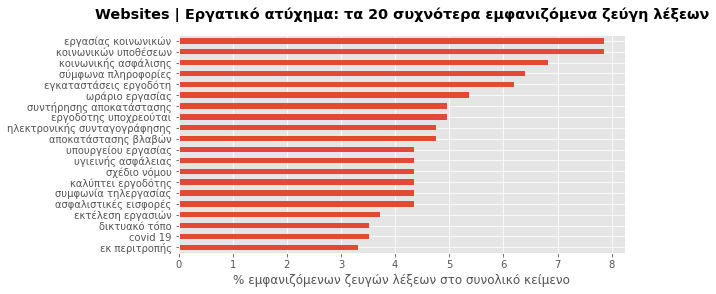

In [ ]:
w_ergatiko_words =  w_ergatiko_results.sum(axis =0)
w_ergatiko_percent = w_ergatiko_words.sort_values(ascending = False).head(20) / w_ergatiko_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = w_ergatiko_percent.plot(kind='barh', figsize=(8,4), color = '#E24A33', xlabel='').invert_yaxis()
plt.title('Websites | Εργατικό ατύχημα: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Τροχαίο**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'])
w_troxaio_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
w_troxaio_results.head(1)

έχασε έλεγχο  έχασε ζωή  αδιευκρίνιστες συνθήκες  αθηνών λαμίας  \
0             0          0                        0              0   

   αντιπρόσωποι μεσολαβούν  ασθενοφόρο εκαβ  ατύχημα σημειώθηκε  \
0                        0                1                   0   

   αυτοκίνητο οδηγούσε  δυστύχημα σημειώθηκε  εθνική οδό  \
0                    1                     0           0   

   εμπορικοί αντιπρόσωποι  εξειδικευμένα καταστήματα  εξετράπη πορείας  \
0                       0                          0                 0   

   λιανικό εμπόριο  μεσολαβούν πώληση  οδηγός αυτοκινήτου  \
0                0                  0                   0   

   πολιτικής προστασίας  σύμφωνα πληροφορίες  τμήμα τροχαίας  χονδρικό εμπόριο  
0                     0                    0               0                 0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

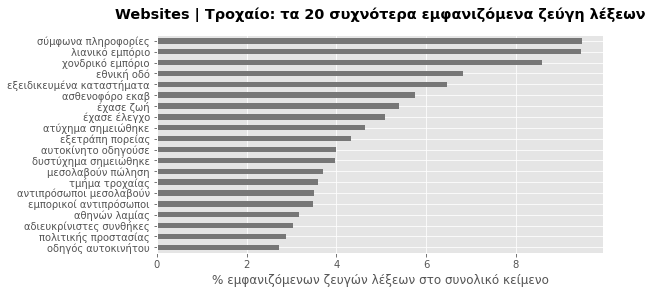

In [ ]:
w_troxaio_words =  w_troxaio_results.sum(axis =0)
w_troxaio_percent = w_troxaio_words.sort_values(ascending = False).head(20) / w_troxaio_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = w_troxaio_percent.plot(kind='barh', figsize=(8,4), color = '#777777', xlabel='').invert_yaxis()
plt.title('Websites | Τροχαίο: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

####**Tweets**

**Ανθρωποκτονία**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'])
t_homocide_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
t_homocide_results.head(1)

31 χρόνια  george floyd  αγία βαρβάρα  βιασμό ελένης  βικτώρια καρύδα  \
0          0             0             0              0                0   

   δίκη τοπαλούδη  διπλή λουτράκι  ελένης τοπαλούδη  ελλαδα κοσμος  \
0               0               0                 0              0   

   ζακ κωστόπουλου  μέση ανατολή  νέα στοιχεία  ξεκινά δίκη  ομόφωνα ένοχοι  \
0                0             0             0            0               0   

   παύλου φύσσα  πυρηνικού επιστήμονα  σούζαν ίτον  τζορτζ φλόιντ  χρυσή αυγή  \
0             0                     0            0              0           0   

   χρόνια παύλου  
0              0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

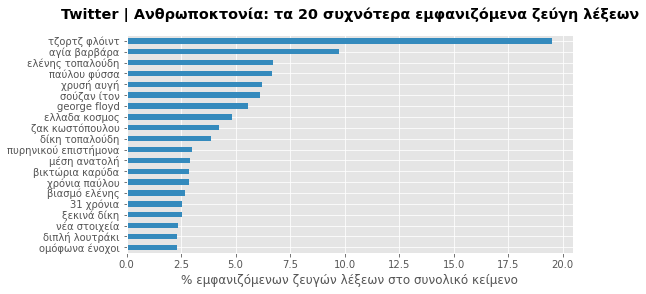

In [ ]:
t_homocide_words =  t_homocide_results.sum(axis =0)
t_homocide_percent = t_homocide_words.sort_values(ascending = False).head(20) / t_homocide_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = t_homocide_percent.plot(kind='barh', figsize=(8,4), color = '#348ABD', xlabel='').invert_yaxis()
plt.title('Twitter | Ανθρωποκτονία: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Αυτοκτονία**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'])
t_suicide_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
t_suicide_results.head(1)

16χρονης τρίκαλα  άγιο στέφανο  έβαλε τέλος  αποδίδει θάνατό  \
0                 0             0            0                0   

   βόλο επιχειρηματία  γηροκομείου άγιο  εισαγγελία τιράνων  \
0                   0                 0                   0   

   επιχειρηματία καλέργη  θάνατος 16χρονης  ιδιοκτήτη γηροκομείου  \
0                      0                 0                      0   

   καρύδης σκέφτομαι  κωνσταντίνος κατσίφας  νέα κρήτη  νέα συγκλονίζει  \
0                  0                      0          0                0   

   ντίνος καρύδης  προσφυγή χάγη  σκέφτομαι σοβαρά  σοκ βόλο  τέλος ζωή  \
0               0              0                 0         0          0   

   φώτης ντούλος  
0              0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

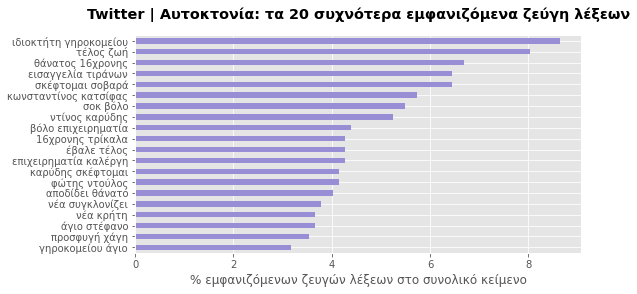

In [ ]:
t_suicide_words =  t_suicide_results.sum(axis =0)
t_suicide_percent = t_suicide_words.sort_values(ascending = False).head(20) / t_suicide_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = t_suicide_percent.plot(kind='barh', figsize=(8,4), color = '#988ED5', xlabel='').invert_yaxis()
plt.title('Twitter | Αυτοκτονία: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Εργατικό ατύχημα**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'])
t_ergatiko_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
t_ergatiko_results.head(1)

motor oil  έπεσε ύψος  έχασε ζωή  αναβατόριο οικοδομής  \
0          0           0          0                     0   

   αυτοδιοικηση πολιτικη  διυλιστήρια motor  δύο τραυματίες  εκτακτο σοβαρό  \
0                      0                  0               0               0   

   εργάτης έπεσε  εργατικό κέντρο  ζώνη περάματος  καθαριότητας δήμου  \
0              0                0               0                   0   

   κατέρρευσε αναβατόριο  κρίσιμη κατάσταση  ναυπηγοεπισκευαστική ζώνη  \
0                      0                  0                          0   

   παλαιό φάληρο  πολιτικη ειδησεις  συνδικάτο οικοδόμων  φάληρο κατέρρευσε  \
0              0                  0                    0                  0   

   ύψος μέτρων  
0            0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

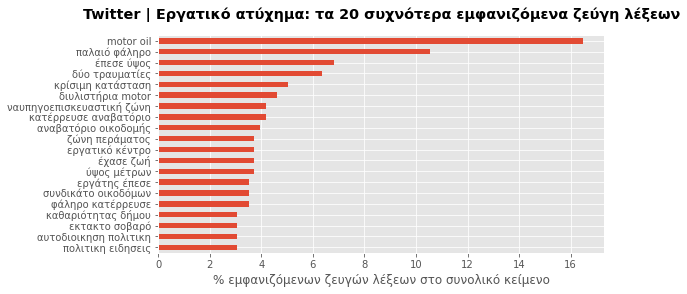

In [ ]:
t_ergatiko_words =  t_ergatiko_results.sum(axis =0)
t_ergatiko_percent = t_ergatiko_words.sort_values(ascending = False).head(20) / t_ergatiko_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = t_ergatiko_percent.plot(kind='barh', figsize=(8,4), color = '#E24A33', xlabel='').invert_yaxis()
plt.title('Twitter | Εργατικό ατύχημα: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

**Τροχαίο**

In [ ]:
count_vector = cv.fit_transform(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'])
t_troxaio_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
t_troxaio_results.head(1)

έχασε ζωή  αθηνών λαμίας  ατύχημα σημειώθηκε  δυστύχημα θύμα  \
0          0              0                   0               0   

   δυστύχημα νεκρό  δύο νεκροί  δύο νεκρούς  δύο τραυματίες  εγνατία οδό  \
0                0           0            0               0            0   

   εθνική οδό  ελλαδα κοσμος  επιχειρηματίας θεόδωρος  θανατηφόρο θύμα  \
0           0              0                        0                0   

   θεσσαλονίκη νεκρός  θεόδωρος νιτσιάκος  κρίσιμη κατάσταση  νεκρός οδηγός  \
0                   0                   0                  0              0   

   οδηγός μηχανής  πατρών πύργου  σοβαρό ατύχημα  
0               0              0               0

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

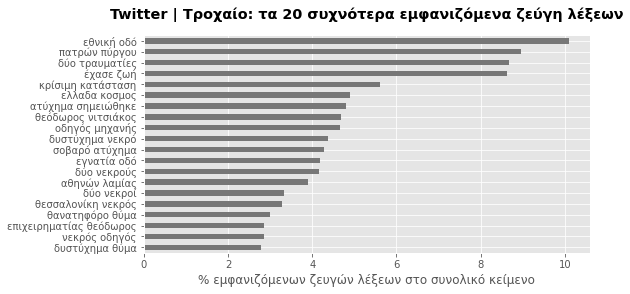

In [ ]:
t_troxaio_words =  t_troxaio_results.sum(axis =0)
t_troxaio_percent = t_troxaio_words.sort_values(ascending = False).head(20) / t_troxaio_words.sum() * 100
#fig = plt.figure()
# '#348ABD', '#988ED5', '#E24A33', '#777777'
ax = t_troxaio_percent.plot(kind='barh', figsize=(8,4), color = '#777777', xlabel='').invert_yaxis()
plt.title('Twitter | Τροχαίο: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')
#plt.xticks(rotation=45, ha='right')
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/top-15-greek.png')

####**Προσπάθεια εύρεσης επιθέτων**

In [ ]:
doc = nlp(u'Mark and John are sincere employees at Google.')
noun_adj_pairs = []
for i,token in enumerate(doc):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i+1,len(doc)):
        if doc[j].pos_ == 'ADJ':
            noun_adj_pairs.append((token,doc[j]))
            break
noun_adj_pairs

In [ ]:
cat_text = comp_df[(comp_df.source != 'twitter') & (comp_df.topic != 'homocide')]['clean_text_new'].str.cat(sep = ' ')
#cat_text = cat_text.replace('  ', ' ')

In [ ]:
cat_text_words = cat_text.split()

In [ ]:
out = []
seen = set()
for word in cat_text_words:
    if word not in seen:
        out.append(word)
    seen.add(word)

In [ ]:
out_string = ' '.join(out)

In [ ]:
doc = gr_nlp(out_string)

In [ ]:
noun_adj_pairs = []
for i,token in enumerate(doc):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i+1,len(doc)):
        if doc[j].pos_ == 'ADJ':
            noun_adj_pairs.append((token,doc[j]))
            break

In [ ]:
adjectives = []
for i,token in enumerate(doc):
    if token.pos_ not in ('NOUN','PROPN'):
        continue
    for j in range(i+1,len(doc)):
        if doc[j].pos_ == 'ADJ':
            adjectives.append(doc[j])
            break

In [ ]:
adj_text = ' '.join(str(v) for v in adjectives)

In [ ]:
adj_text[0:100]

'25χρονη 25χρονη πρωτοχρονιάς πρωτοχρονιάς πρωτοχρονιάς 25χρονης 25χρονης 25χρονης αστυνομικού ιλιγγι'

###**9 ---- Wordclouds**

**Websites | Homocide**

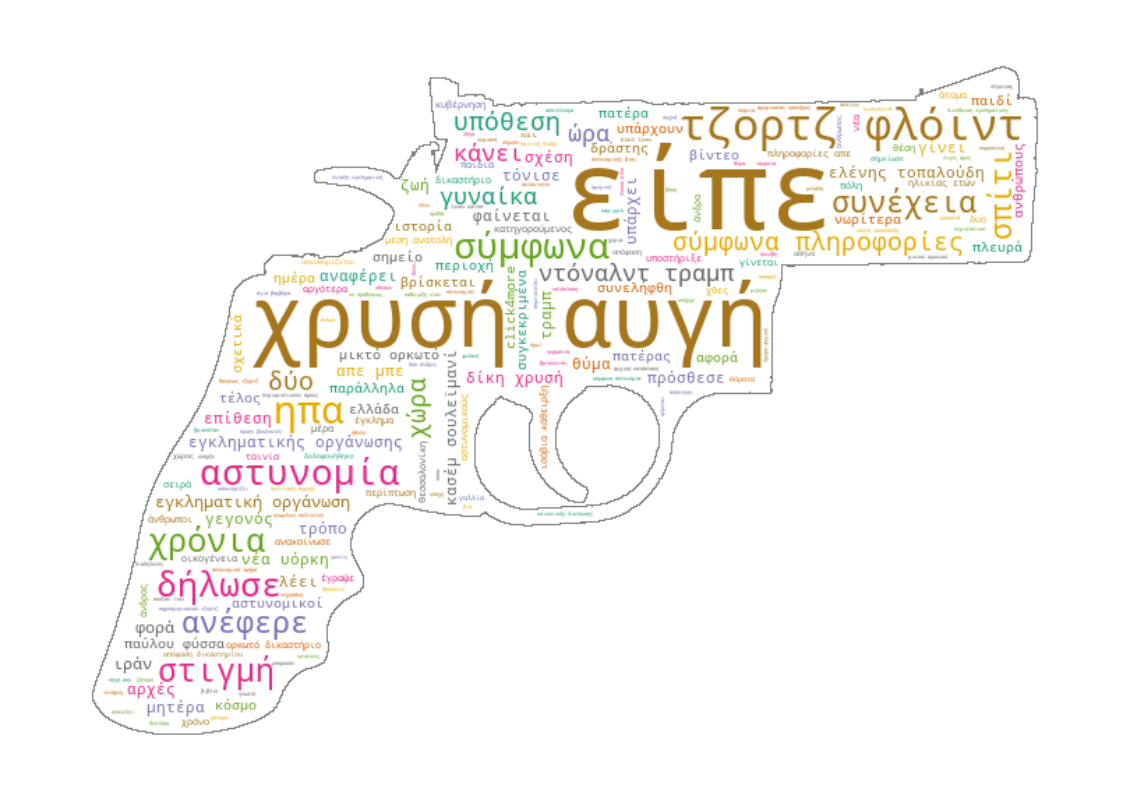

In [ ]:
# open the image-mask and use np.array to transform the file to an array
revolver_right_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/revolver-2-right.png'))

# make all values greater than 3 -> 255 (white)
revolver_right_mask=np.where(revolver_right_mask > 3, 255, revolver_right_mask)

wordcloud1 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = revolver_right_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud1.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-websites-homocide.png')

**Twitter | Homocide**

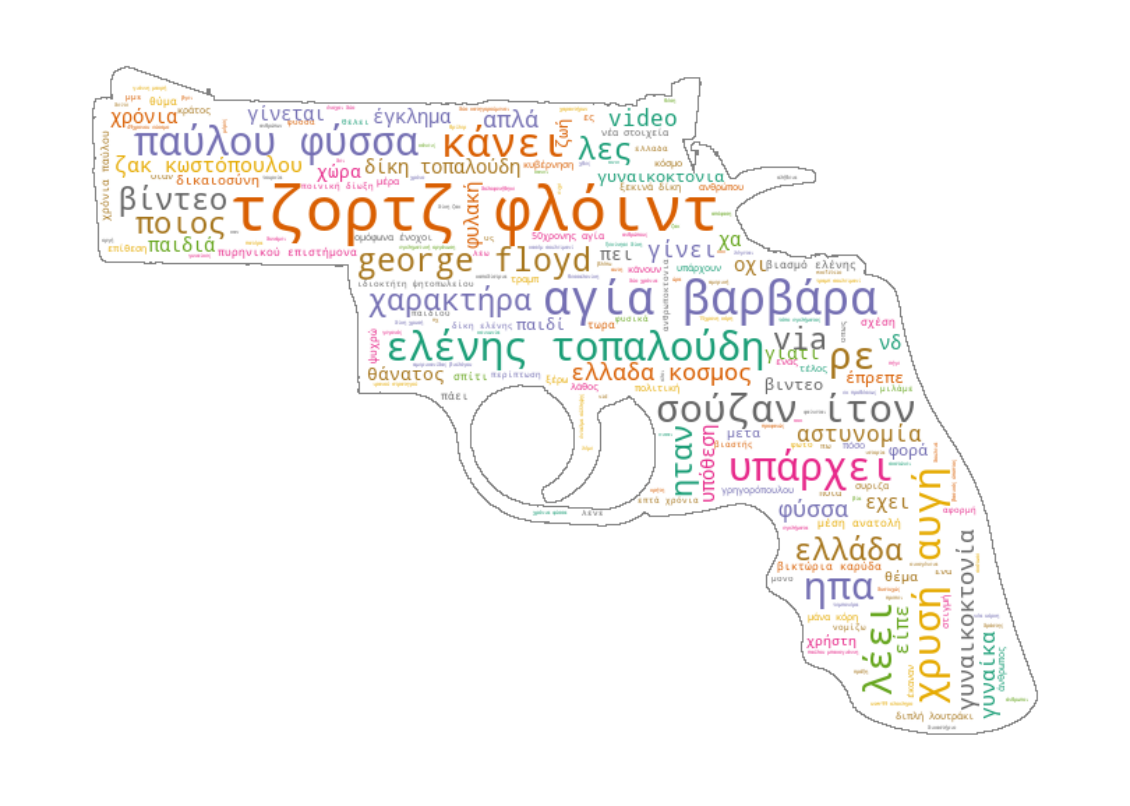

In [ ]:
# open the image-mask and use np.array to transform the file to an array
revolver_left_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/revolver-2-left.png'))

# make all values greater than 3 -> 255 (white)
revolver_left_mask=np.where(revolver_left_mask > 3, 255, revolver_left_mask)

wordcloud2 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = revolver_left_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud2, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud2.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-twitter-homocide.png')

**Websites | Suicide**

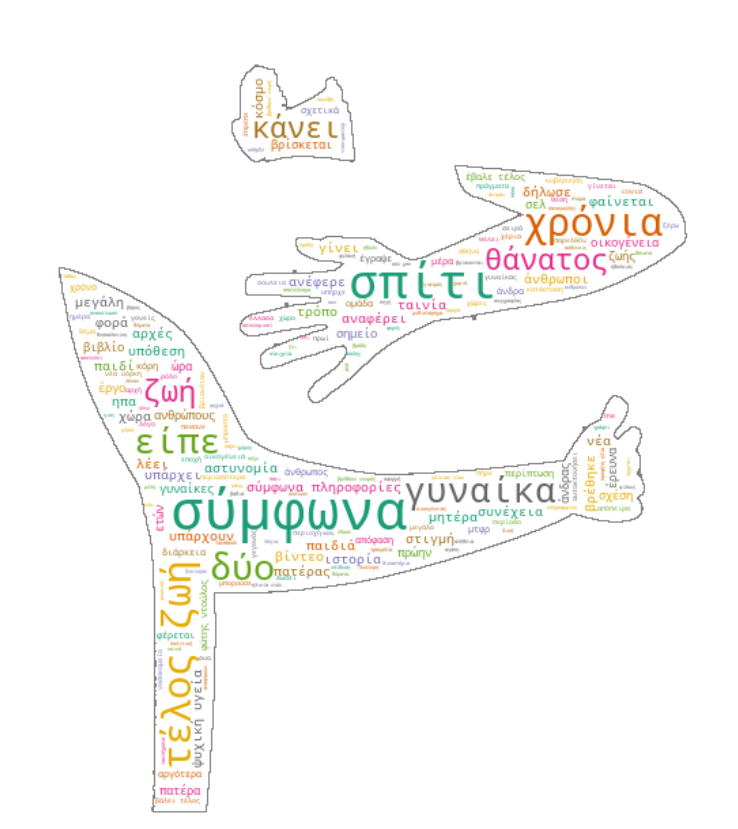

In [ ]:
# open the image-mask and use np.array to transform the file to an array
suicide_left_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/suicide-left.png'))

# make all values greater than 3 -> 255 (white)
suicide_left_mask=np.where(suicide_left_mask > 3, 255, suicide_left_mask)

wordcloud3 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = suicide_left_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud3, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud3.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-websites-suicide.png')

**Twitter | Suicide**

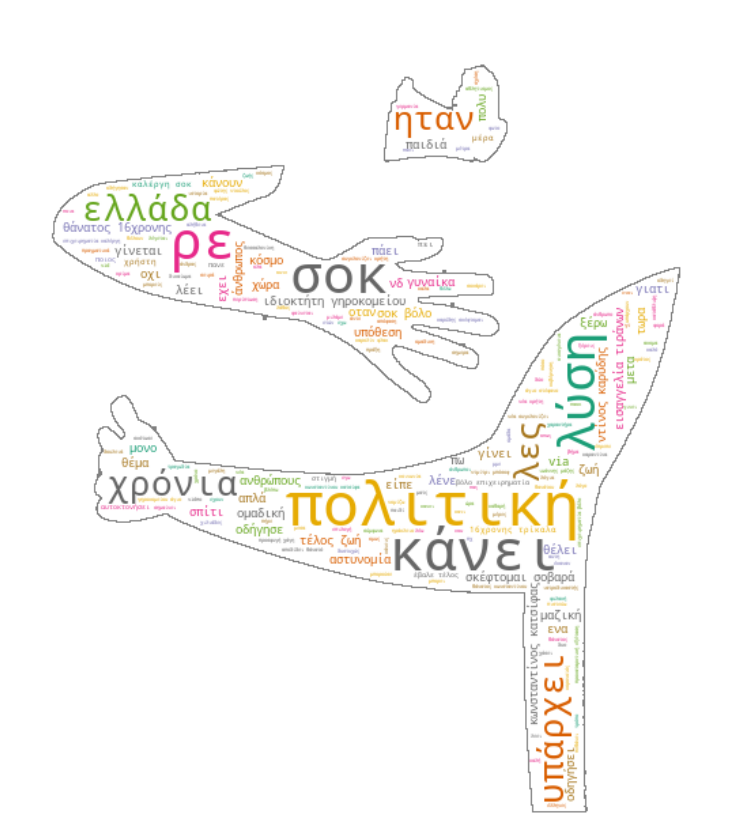

In [ ]:
# open the image-mask and use np.array to transform the file to an array
suicide_right_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/suicide-right.png'))

# make all values greater than 3 -> 255 (white)
suicide_right_mask=np.where(suicide_right_mask > 3, 255, suicide_right_mask)

wordcloud4 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = suicide_right_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud4, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud4.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-twitter-suicide.png')

**Websites | Ergatiko**

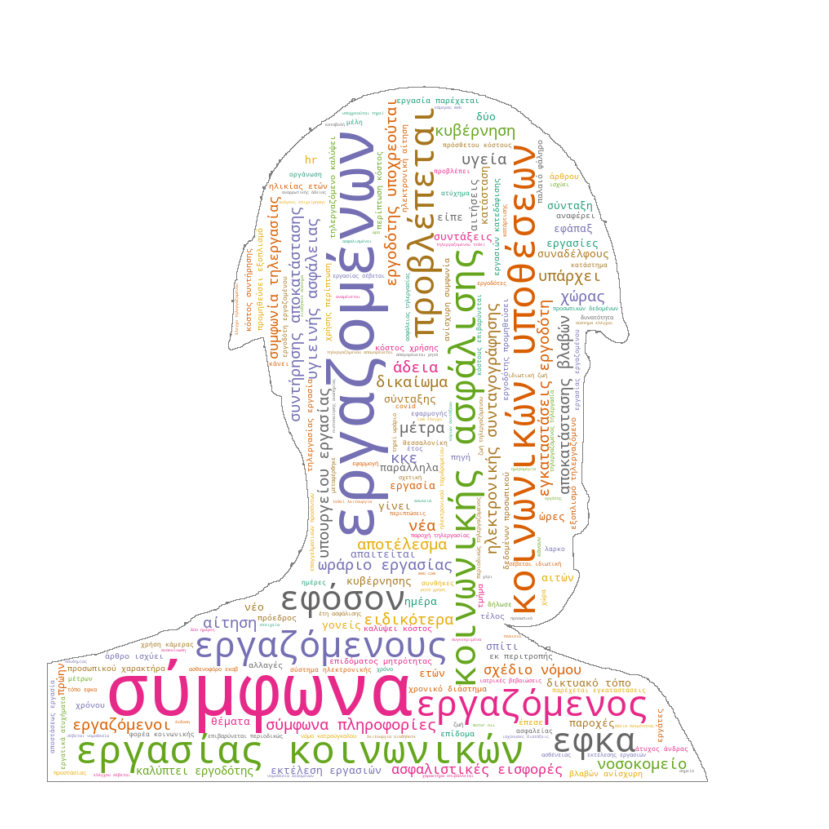

In [ ]:
# open the image-mask and use np.array to transform the file to an array
ergatiko_left_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/ergatiko-left.png'))

# make all values greater than 3 -> 255 (white)
ergatiko_left_mask=np.where(ergatiko_left_mask > 3, 255, ergatiko_left_mask)

wordcloud5 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = ergatiko_left_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud5, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud5.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-websites-ergatiko.png')

**Twitter | Ergatiko**

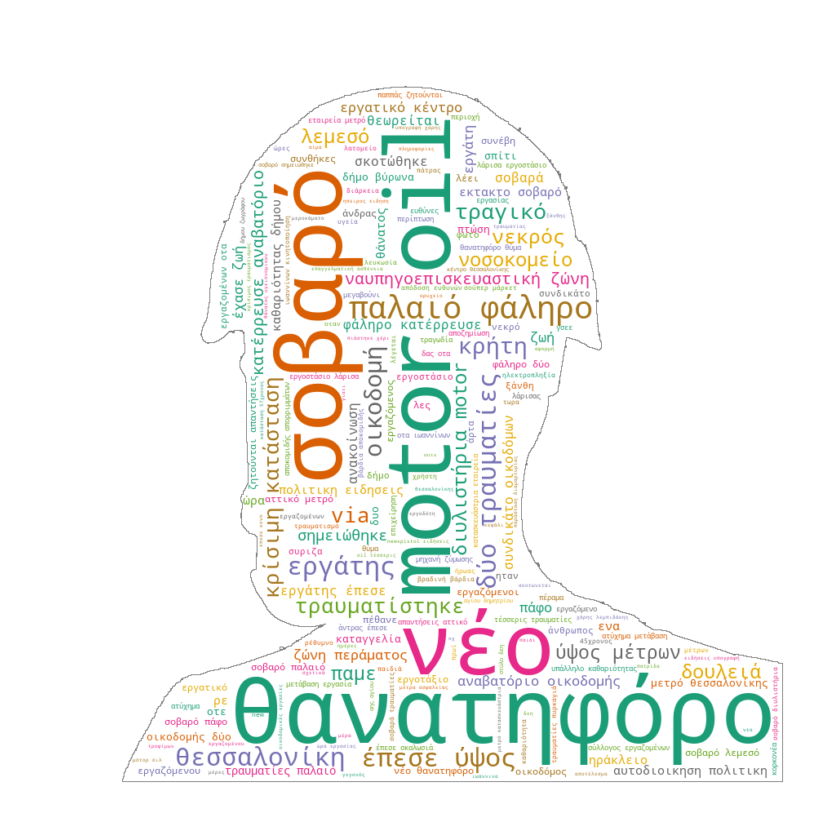

In [ ]:
# open the image-mask and use np.array to transform the file to an array
ergatiko_right_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/ergatiko-right.png'))

# make all values greater than 3 -> 255 (white)
ergatiko_right_mask=np.where(ergatiko_right_mask > 3, 255, ergatiko_right_mask)

wordcloud6 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = ergatiko_right_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud6, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud6.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-twitter-ergatiko.png')

**Websites | Troxaio**

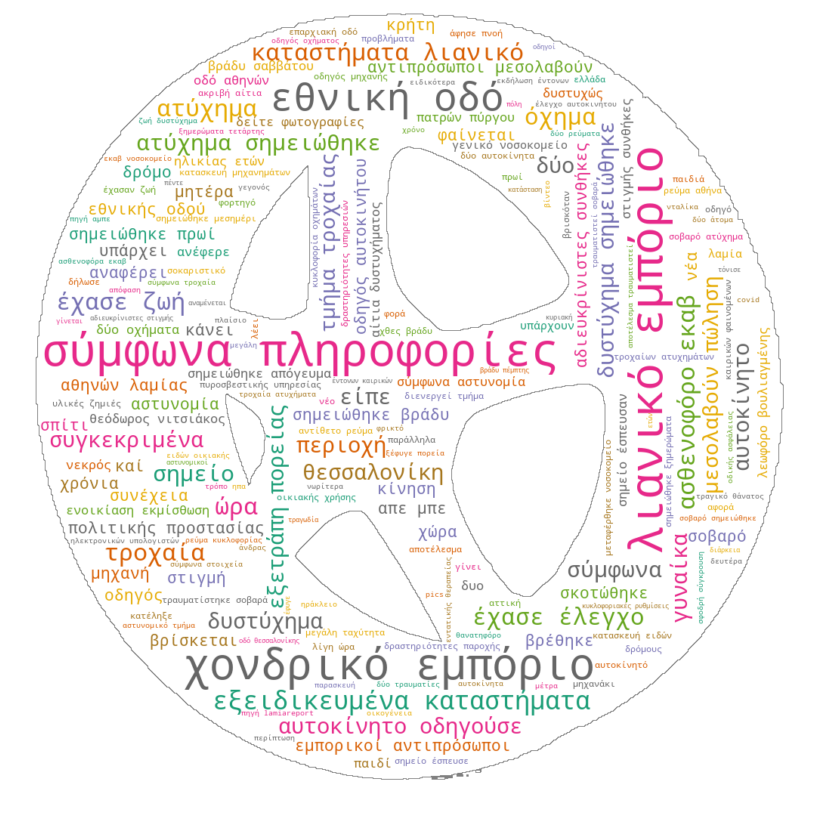

In [ ]:
# open the image-mask and use np.array to transform the file to an array
troxaio_left_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/troxaio-left.png'))

# make all values greater than 3 -> 255 (white)
troxaio_left_mask=np.where(troxaio_left_mask > 3, 255, troxaio_left_mask)

wordcloud7 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = troxaio_left_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud7, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud7.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-websites-troxaio.png')

**Websites | Troxaio**

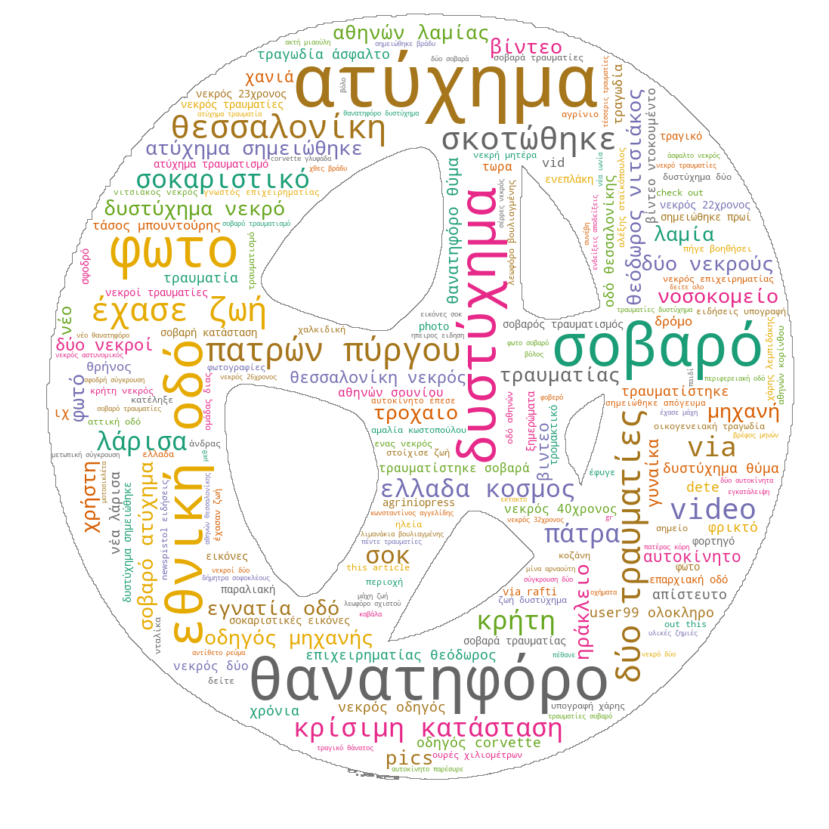

In [ ]:
# open the image-mask and use np.array to transform the file to an array
troxaio_right_mask=np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/troxaio-right.png'))

# make all values greater than 3 -> 255 (white)
troxaio_left_mask=np.where(troxaio_right_mask > 3, 255, troxaio_right_mask)

wordcloud8 = WordCloud(
      stopwords = gr_stopwords,
      max_words=200,
      width = 2000,
      height = 1000,
      mask = troxaio_right_mask,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud8, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
# save image
wordcloud8.to_file('/content/gdrive/MyDrive/Colab Notebooks/Scraping/CSVs/ErgasiaEDDE2/masks/wordcloud-twitter-troxaio.png')

###**10 ---- Cosine similarity**

####**Websites / Twitter**

**Create corpora df joinining tweets to one string for each websites/twitter - topic** 

In [ ]:
# create an empty dictionary to store joined tweets' text
corpora_dict = {}
# add websites homocide corpus to dictionary
corpora_dict['websites_homocide'] = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add websites suicide corpus to dictionary
corpora_dict['websites_suicide'] = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add websites ergatiko corpus to dictionary
corpora_dict['websites_ergatiko'] = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add websites troxaio corpus to dictionary
corpora_dict['websites_troxaio'] = comp_df[(comp_df.source != 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add twitter homocide corpus to dictionary
corpora_dict['twitter_homocide'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add twitter suicide corpus to dictionary
corpora_dict['twitter_suicide'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add twitter ergatiko corpus to dictionary
corpora_dict['twitter_ergatiko'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add twitter troxaio corpus to dictionary
corpora_dict['twitter_troxaio'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# create corpora dataframe from dictionary
corpora_df = pd.DataFrame.from_dict(corpora_dict, orient = 'index')
# rename column name to 'text'
corpora_df.rename(columns = {0:'text'}, inplace = True)
corpora_df.shape

(8, 1)

**Tfidf vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(corpora_df['text'])  #finds the tfidf score with normalization
corpora_results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) 
corpora_results.head()

00       000        10        11        12        13        14  \
0  0.024525  0.041960  0.050834  0.027156  0.026888  0.030812  0.020869   
1  0.026222  0.053553  0.054291  0.030285  0.033609  0.020682  0.026222   
2  0.029036  0.047514  0.089749  0.050154  0.063352  0.036955  0.073911   
3  0.070177  0.043682  0.110381  0.099435  0.091660  0.052377  0.038669   
4  0.011428  0.017029  0.041853  0.016877  0.031257  0.019224  0.016272   

         15        16        17  ...      χώρα     χώρας      χώρο     ψυχρώ  \
0  0.028048  0.012173  0.019352  ...  0.074266  0.025818  0.024034  0.011606   
1  0.039149  0.017359  0.024006  ...  0.063163  0.022160  0.034348  0.002311   
2  0.084470  0.018478  0.005279  ...  0.064913  0.055433  0.044874  0.000000   
3  0.032838  0.030997  0.028848  ...  0.029616  0.016879  0.012890  0.000000   
4  0.030955  0.006812  0.017180  ...  0.040268  0.007720  0.004919  0.052371   

       όπλο     όχημα   ύποπτος      ύψος       ώρα      ώρες  
0  0.042865  0.011103  0.023658  0.011683  0.084411  0.038883  
1  0.047063  0.002955  0.008781  0.015143  0.063894  0.037672  
2  0.000000  0.005279  0.000000  0.060713  0.087109  0.092389  
3  0.005260  0.097286  0.000512  0.099332  0.077850  0.047774  
4  0.012436  0.001514  0.037597  0.001438  0.026414  0.010066  

[5 rows x 500 columns]

**Cosine similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train, tfidf_matrix_train))  #here all the element of tfidf_matrix_train are matched with all other elements
arr = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

([<matplotlib.axis.YTick at 0x7f83d2d24510>,
 [Text(0, 0.5, 'websites\nανθρωποκτονία'),
  Text(0, 1.5, 'websites\nαυτοκτονία'),
  Text(0, 2.5, 'websites\nεργατικό\nατύχημα'),
  Text(0, 3.5, 'websites\nτροχαίο'),
  Text(0, 4.5, 'twitter\nανθρωποκτονία'),
  Text(0, 5.5, 'twitter\nαυτοκτονία'),
  Text(0, 6.5, 'twitter\nεργατικό\nατύχημα'),
  Text(0, 7.5, 'twitter\nτροχαίο')])

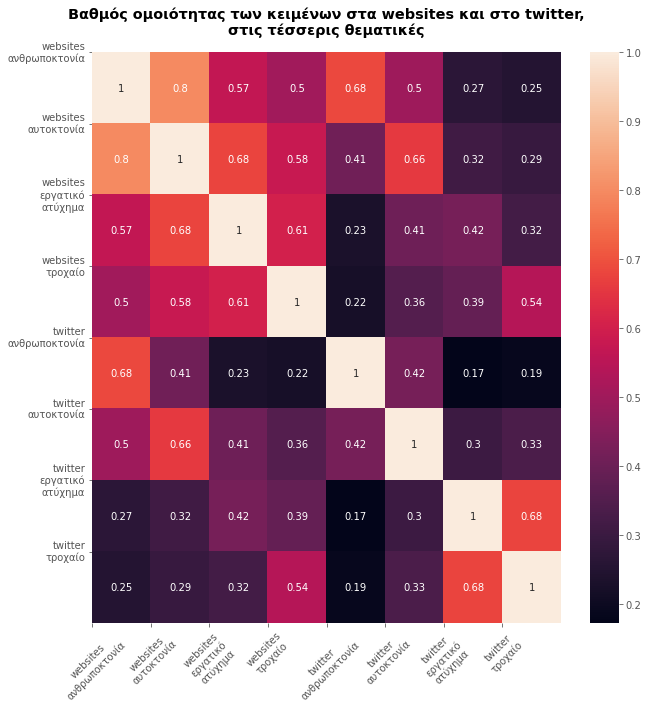

In [ ]:
import seaborn as sns
plt.figure(figsize=(10.5, 10.5))
#annot = True #to print the values inside the square

plt.title('Βαθμός ομοιότητας των κειμένων στα websites και στο twitter,\nστις τέσσερις θεματικές', y=1.02, fontweight='bold')
sns.heatmap(data=arr, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['websites\nανθρωποκτονία','websites\nαυτοκτονία','websites\nεργατικό\nατύχημα', 'websites\nτροχαίο', 'twitter\nανθρωποκτονία','twitter\nαυτοκτονία','twitter\nεργατικό\nατύχημα','twitter\nτροχαίο'], rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['websites\nανθρωποκτονία','websites\nαυτοκτονία','websites\nεργατικό\nατύχημα', 'websites\nτροχαίο', 'twitter\nανθρωποκτονία','twitter\nαυτοκτονία','twitter\nεργατικό\nατύχημα','twitter\nτροχαίο'], rotation=0)
#plt.xticks(xs,labels, ha='left')



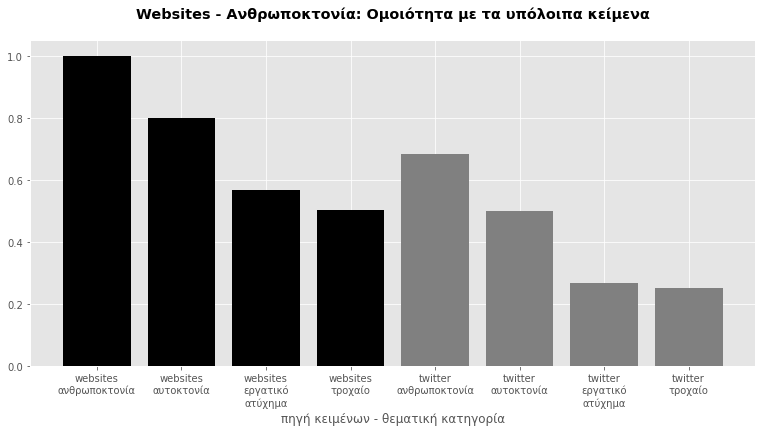

In [ ]:
xs = pd.DataFrame(arr).columns
ys = pd.DataFrame(arr).loc[0].head(8)
labels = ['websites\nανθρωποκτονία','websites\nαυτοκτονία','websites\nεργατικό\nατύχημα','websites\nτροχαίο', 'twitter\nανθρωποκτονία', 'twitter\nαυτοκτονία','twitter\nεργατικό\nατύχημα','twitter\nτροχαίο']

plt.rcParams["figure.figsize"] = (13,6)

plt.bar(xs,ys, color=['black', 'black','black','black','gray','gray','gray','gray'])
plt.title('Websites - Ανθρωποκτονία: Ομοιότητα με τα υπόλοιπα κείμενα', y=1.05, fontweight='bold')
plt.xlabel('πηγή κειμένων - θεματική κατηγορία')

plt.xticks(xs,labels)#,rotation=45, ha='center')

# reset figure size
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

####**Websites**

**Create corpora df joinining tweets to one string for each website - topic** 

In [ ]:
# create an empty dictionary to store joined tweets' text
corpora2_dict = {}
# add cnn homocide corpus to dictionary
corpora2_dict['cnn_homocide'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add cnn suicide corpus to dictionary
corpora2_dict['cnn_suicide'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add cnn ergatiko corpus to dictionary
corpora2_dict['cnn_ergatiko'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add cnn troxaio corpus to dictionary
corpora2_dict['cnn_troxaio'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# add dikaiologitika homocide corpus to dictionary
corpora2_dict['dikaiologitika_homocide'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika suicide corpus to dictionary
corpora2_dict['dikaiologitika_suicide'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika ergatiko corpus to dictionary
corpora2_dict['dikaiologitika_ergatiko'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika troxaio corpus to dictionary
corpora2_dict['dikaiologitika_troxaio'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# add lifo homocide corpus to dictionary
corpora2_dict['lifo_homocide'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add lifo suicide corpus to dictionary
corpora2_dict['lifo_suicide'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add lifo ergatiko corpus to dictionary
corpora2_dict['lifo_ergatiko'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add lifo troxaio corpus to dictionary
corpora2_dict['lifo_troxaio'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# add naftemporiki homocide corpus to dictionary
corpora2_dict['naftemporiki_homocide'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki suicide corpus to dictionary
corpora2_dict['naftemporiki_suicide'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki ergatiko corpus to dictionary
corpora2_dict['naftemporiki_ergatiko'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki troxaio corpus to dictionary
corpora2_dict['naftemporiki_troxaio'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# add newsbomb homocide corpus to dictionary
corpora2_dict['newsbomb_homocide'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb suicide corpus to dictionary
corpora2_dict['newsbomb_suicide'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb ergatiko corpus to dictionary
corpora2_dict['newsbomb_ergatiko'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb troxaio corpus to dictionary
corpora2_dict['newsbomb_troxaio'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# add newsit homocide corpus to dictionary
corpora2_dict['newsit_homocide'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add newsit suicide corpus to dictionary
corpora2_dict['newsit_suicide'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add newsit ergatiko corpus to dictionary
corpora2_dict['newsit_ergatiko'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add newsit troxaio corpus to dictionary
corpora2_dict['newsit_troxaio'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# create corpora dataframe from dictionary
corpora2_df = pd.DataFrame.from_dict(corpora2_dict, orient = 'index')
# rename column name to 'text'
corpora2_df.rename(columns = {0:'text'}, inplace = True)
corpora2_df.shape

(24, 1)

**Tfidf vectorization**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer2 = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train2 = tfidf_vectorizer2.fit_transform(corpora2_df['text'])  #finds the tfidf score with normalization
corpora2_results = pd.DataFrame(tfidf_matrix_train2.toarray(), columns=tfidf_vectorizer2.get_feature_names_out()) 
corpora2_results.head()

00       000        01        02        10        11        12  \
0  0.022441  0.037258  0.002859  0.003574  0.026826  0.015840  0.014445   
1  0.004680  0.060451  0.000000  0.000000  0.009359  0.009741  0.004680   
2  0.042579  0.000000  0.000000  0.000000  0.042579  0.088633  0.085157   
3  0.044442  0.004605  0.000000  0.003622  0.024835  0.010884  0.014378   
4  0.028645  0.039010  0.004336  0.004670  0.053920  0.026307  0.025997   

         13        14        15  ...     χώρας     χώρες      χώρο    ψυχική  \
0  0.016660  0.013382  0.016108  ...  0.025150  0.014546  0.017182  0.016406   
1  0.005496  0.000000  0.009741  ...  0.010140  0.000000  0.019483  0.062963   
2  0.000000  0.000000  0.000000  ...  0.000000  0.096043  0.000000  0.000000   
3  0.009210  0.000000  0.009523  ...  0.004248  0.001474  0.001360  0.001599   
4  0.045795  0.022262  0.029063  ...  0.019559  0.008959  0.016536  0.021199   

       όπλο     όρους     όχημα      ύψος       ώρα      ώρες  
0  0.052268  0.011358  0.012867  0.011737  0.101999  0.030739  
1  0.065603  0.000000  0.000000  0.020279  0.055769  0.030419  
2  0.000000  0.000000  0.000000  0.138386  0.046129  0.000000  
3  0.006663  0.000000  0.155765  0.138778  0.073637  0.019825  
4  0.036506  0.040337  0.012675  0.017473  0.085277  0.035206  

[5 rows x 500 columns]

**Cosine similarity**

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train2, tfidf_matrix_train2))  #here all the element of tfidf_matrix_train are matched with all other elements
arr2 = cosine_similarity(tfidf_matrix_train2, tfidf_matrix_train2)

([<matplotlib.axis.YTick at 0x7f8d8d335e50>,
 [Text(0, 0.5, 'cnn\nανθρωποκτονία'),
  Text(0, 1.5, 'cnn\nαυτοκτονία'),
  Text(0, 2.5, 'cnn\nεργατικό\nατύχημα'),
  Text(0, 3.5, 'cnn\nτροχαίο'),
  Text(0, 4.5, 'dikaiologitika\nανθρωποκτονία'),
  Text(0, 5.5, 'dikaiologitika\nαυτοκτονία'),
  Text(0, 6.5, 'dikaiologitika\nεργατικό\nατύχημα'),
  Text(0, 7.5, 'dikaiologitika\nτροχαίο'),
  Text(0, 8.5, 'lifo\nανθρωποκτονία'),
  Text(0, 9.5, 'lifo\nαυτοκτονία'),
  Text(0, 10.5, 'lifo\nεργατικό\nατύχημα'),
  Text(0, 11.5, 'lifo\nτροχαίο'),
  Text(0, 12.5, 'naftemporiki\nανθρωποκτονία'),
  Text(0, 13.5, 'naftemporiki\nαυτοκτονία'),
  Text(0, 14.5, 'naftemporiki\nεργατικό\nατύχημα'),
  Text(0, 15.5, 'naftemporiki\nτροχαίο'),
  Text(0, 16.5, 'newsbomb\nανθρωποκτονία'),
  Text(0, 17.5, 'newsbomb\nαυτοκτονία'),
  Text(0, 18.5, 'newsbomb\nεργατικό\nατύχημα'),
  Text(0, 19.5, 'newsbomb\nτροχαίο'),
  Text(0, 20.5, 'newsit\nανθρωποκτονία'),
  Text(0, 21.5, 'newsit\nαυτοκτονία'),
  Text(0, 22.5, 'newsit\n

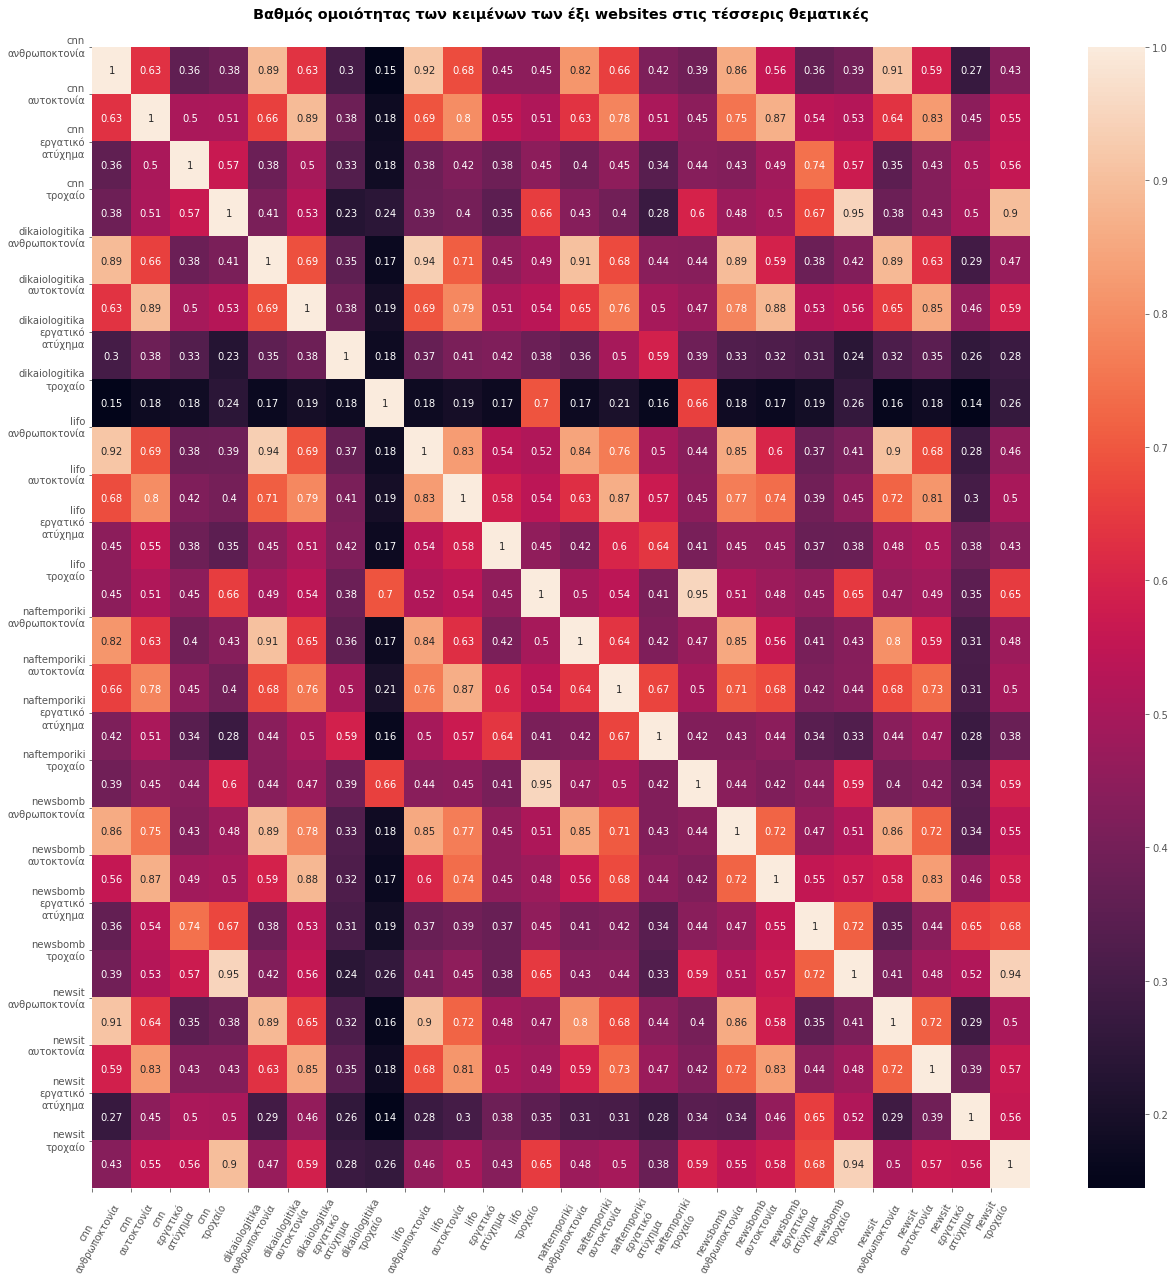

In [ ]:
#import seaborn as sns
plt.figure(figsize=(21, 21))
# annot = True to print the values inside the square

plt.title('Βαθμός ομοιότητας των κειμένων των έξι websites στις τέσσερις θεματικές', y=1.02, fontweight='bold')
sns.heatmap(data=arr2, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['cnn\nανθρωποκτονία','cnn\nαυτοκτονία','cnn\nεργατικό\nατύχημα', 'cnn\nτροχαίο', 'dikaiologitika\nανθρωποκτονία','dikaiologitika\nαυτοκτονία','dikaiologitika\nεργατικό\nατύχημα','dikaiologitika\nτροχαίο', 'lifo\nανθρωποκτονία','lifo\nαυτοκτονία','lifo\nεργατικό\nατύχημα','lifo\nτροχαίο', 'naftemporiki\nανθρωποκτονία','naftemporiki\nαυτοκτονία','naftemporiki\nεργατικό\nατύχημα','naftemporiki\nτροχαίο', 'newsbomb\nανθρωποκτονία','newsbomb\nαυτοκτονία','newsbomb\nεργατικό\nατύχημα','newsbomb\nτροχαίο', 'newsit\nανθρωποκτονία','newsit\nαυτοκτονία','newsit\nεργατικό\nατύχημα','newsit\nτροχαίο'], rotation=60)
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ['cnn\nανθρωποκτονία','cnn\nαυτοκτονία','cnn\nεργατικό\nατύχημα', 'cnn\nτροχαίο', 'dikaiologitika\nανθρωποκτονία','dikaiologitika\nαυτοκτονία','dikaiologitika\nεργατικό\nατύχημα','dikaiologitika\nτροχαίο', 'lifo\nανθρωποκτονία','lifo\nαυτοκτονία','lifo\nεργατικό\nατύχημα','lifo\nτροχαίο', 'naftemporiki\nανθρωποκτονία','naftemporiki\nαυτοκτονία','naftemporiki\nεργατικό\nατύχημα','naftemporiki\nτροχαίο', 'newsbomb\nανθρωποκτονία','newsbomb\nαυτοκτονία','newsbomb\nεργατικό\nατύχημα','newsbomb\nτροχαίο', 'newsit\nανθρωποκτονία','newsit\nαυτοκτονία','newsit\nεργατικό\nατύχημα','newsit\nτροχαίο'], rotation=0)

#plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['websites\nανθρωποκτονία','websites\nαυτοκτονία','websites\nεργατικό\nατύχημα', 'websites\nτροχαίο', 'twitter\nανθρωποκτονία','twitter\nαυτοκτονία','twitter\nεργατικό\nατύχημα','twitter\nτροχαίο'], rotation=0)
#plt.xticks(xs,labels, ha='left')



**Create corpora df joinining tweets to one string for each topic-source** 

In [ ]:
# create an empty dictionary to store joined tweets' text
homocide_dict = {}
# add cnn homocide corpus to dictionary
homocide_dict['cnn_homocide'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika homocide corpus to dictionary
homocide_dict['dikaiologitika_homocide'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add lifo homocide corpus to dictionary
homocide_dict['lifo_homocide'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki homocide corpus to dictionary
homocide_dict['naftemporiki_homocide'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb homocide corpus to dictionary
homocide_dict['newsbomb_homocide'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add newsit homocide corpus to dictionary
homocide_dict['newsit_homocide'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')
# add twitter homocide corpus to dictionary
homocide_dict['twitter_homocide'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'homocide')]['clean_text_new'].str.cat(sep = ' ')

suicide_dict = {}
# add cnn suicide corpus to dictionary
suicide_dict['cnn_suicide'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika suicide corpus to dictionary
suicide_dict['dikaiologitika_suicide'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add lifo suicide corpus to dictionary
suicide_dict['lifo_suicide'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki suicide corpus to dictionary
suicide_dict['naftemporiki_suicide'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb suicide corpus to dictionary
suicide_dict['newsbomb_suicide'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add newsit suicide corpus to dictionary
suicide_dict['newsit_suicide'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')
# add twitter suicide corpus to dictionary
suicide_dict['twitter_suicide'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'suicide')]['clean_text_new'].str.cat(sep = ' ')

ergatiko_dict = {}
# add cnn ergatiko corpus to dictionary
ergatiko_dict['cnn_ergatiko'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika ergatiko corpus to dictionary
ergatiko_dict['dikaiologitika_ergatiko'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add lifo ergatiko corpus to dictionary
ergatiko_dict['lifo_ergatiko'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki ergatiko corpus to dictionary
ergatiko_dict['naftemporiki_ergatiko'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb ergatiko corpus to dictionary
ergatiko_dict['newsbomb_ergatiko'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add newsit ergatiko corpus to dictionary
ergatiko_dict['newsit_ergatiko'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')
# add twitter ergatiko corpus to dictionary
ergatiko_dict['twitter_ergatiko'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'ergatiko')]['clean_text_new'].str.cat(sep = ' ')

troxaio_dict = {}
# add cnn troxaio corpus to dictionary
troxaio_dict['cnn_troxaio'] = comp_df[(comp_df.source == 'cnn') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add dikaiologitika troxaio corpus to dictionary
troxaio_dict['dikaiologitika_troxaio'] = comp_df[(comp_df.source == 'dikaiologitika') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add lifo troxaio corpus to dictionary
troxaio_dict['lifo_troxaio'] = comp_df[(comp_df.source == 'lifo') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add naftemporiki troxaio corpus to dictionary
troxaio_dict['naftemporiki_troxaio'] = comp_df[(comp_df.source == 'naftemporiki') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add newsbomb troxaio corpus to dictionary
troxaio_dict['newsbomb_troxaio'] = comp_df[(comp_df.source == 'newsbomb') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add newsit troxaio corpus to dictionary
troxaio_dict['newsit_troxaio'] = comp_df[(comp_df.source == 'newsit') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')
# add twitter troxaio corpus to dictionary
troxaio_dict['twitter_troxaio'] = comp_df[(comp_df.source == 'twitter') & (comp_df.topic == 'troxaio')]['clean_text_new'].str.cat(sep = ' ')

# create homocide corpora dataframe from dictionary
homocide_df = pd.DataFrame.from_dict(homocide_dict, orient = 'index')
# rename column name to 'text'
homocide_df.rename(columns = {0:'text'}, inplace = True)
homocide_df.shape

# create suicide corpora dataframe from dictionary
suicide_df = pd.DataFrame.from_dict(suicide_dict, orient = 'index')
# rename column name to 'text'
suicide_df.rename(columns = {0:'text'}, inplace = True)
suicide_df.shape

# create ergatiko corpora dataframe from dictionary
ergatiko_df = pd.DataFrame.from_dict(ergatiko_dict, orient = 'index')
# rename column name to 'text'
ergatiko_df.rename(columns = {0:'text'}, inplace = True)
ergatiko_df.shape

# create troxaio corpora dataframe from dictionary
troxaio_df = pd.DataFrame.from_dict(troxaio_dict, orient = 'index')
# rename column name to 'text'
troxaio_df.rename(columns = {0:'text'}, inplace = True)
troxaio_df.shape

(7, 1)

**Tfidf vectorization - homocide**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_homo = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train_homo = tfidf_vectorizer_homo.fit_transform(homocide_df['text'])  #finds the tfidf score with normalization
homocide_results = pd.DataFrame(tfidf_matrix_train_homo.toarray(), columns=tfidf_vectorizer_homo.get_feature_names_out()) 
homocide_results.head()

00       000        10        11        12        13        14  \
0  0.027364  0.038687  0.032711  0.018557  0.017613  0.017299  0.014468   
1  0.033971  0.039395  0.063946  0.029975  0.030831  0.046246  0.023409   
2  0.024982  0.057170  0.059252  0.031387  0.031227  0.041636  0.022420   
3  0.030947  0.058025  0.063828  0.030947  0.019342  0.038684  0.029013   
4  0.018586  0.022782  0.042267  0.028778  0.032075  0.015888  0.027279   

         15   15χρονη        17  ...      χώρα     χώρας      χώρο     ψυχρώ  \
0  0.018871  0.012266  0.017613  ...  0.069510  0.028307  0.020130  0.009983   
1  0.033115  0.014845  0.017128  ...  0.045961  0.021410  0.018841  0.010355   
2  0.030587  0.012171  0.020818  ...  0.093362  0.036032  0.032829  0.009076   
3  0.029013  0.007737  0.029013  ...  0.070597  0.023210  0.019342  0.000000   
4  0.027579  0.015288  0.021883  ...  0.044366  0.013490  0.023382  0.018689   

      όνομα      όπλο     όρους   ύποπτος       ώρα      ώρες  
0  0.012581  0.050009  0.011323  0.013525  0.114802  0.034598  
1  0.012561  0.033971  0.039110  0.023694  0.093349  0.038539  
2  0.023861  0.030106  0.019057  0.016494  0.069341  0.040676  
3  0.005803  0.040618  0.067696  0.023210  0.064795  0.058025  
4  0.012290  0.059954  0.008394  0.025181  0.090530  0.044366  

[5 rows x 500 columns]

**Tfidf vectorization - suicide**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_sui = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train_sui = tfidf_vectorizer_sui.fit_transform(suicide_df['text'])  #finds the tfidf score with normalization
suicide_results = pd.DataFrame(tfidf_matrix_train_sui.toarray(), columns=tfidf_vectorizer_sui.get_feature_names_out()) 
suicide_results.head()

00       000        10       100        11        12        13  \
0  0.004776  0.052533  0.009551  0.004776  0.009551  0.004776  0.004776   
1  0.024944  0.043652  0.053007  0.012472  0.034298  0.046770  0.015590   
2  0.014730  0.047135  0.060391  0.013257  0.023567  0.025040  0.015466   
3  0.016332  0.101256  0.058794  0.009799  0.032663  0.029397  0.029397   
4  0.034942  0.021353  0.015530  0.003882  0.029118  0.023295  0.013589   

         14        15        16  ...     χώρας     χώρες      χώρο    ψυχική  \
0  0.000000  0.009551  0.004776  ...  0.009551  0.000000  0.019103  0.052533   
1  0.014138  0.021826  0.018708  ...  0.009354  0.021206  0.031180  0.053007   
2  0.027549  0.041979  0.016203  ...  0.022094  0.028384  0.025777  0.047871   
3  0.029620  0.042462  0.022864  ...  0.052261  0.125884  0.026131  0.120854   
4  0.039608  0.021353  0.009706  ...  0.007765  0.019804  0.031060  0.009706   

   ψυχολογικά      όπλο     όροφο        ών       ώρα      ώρες  
0    0.023878  0.052533  0.085962  0.052533  0.052533  0.028654  
1    0.043652  0.077951  0.046770  0.034298  0.059243  0.031180  
2    0.011047  0.020621  0.018412  0.027250  0.047135  0.028723  
3    0.019598  0.032663  0.019598  0.091457  0.062060  0.016332  
4    0.017471  0.056296  0.036883  0.019412  0.064060  0.050472  

[5 rows x 500 columns]

**Tfidf vectorization - ergatiko**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_erg = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train_erg = tfidf_vectorizer_erg.fit_transform(ergatiko_df['text'])  #finds the tfidf score with normalization
ergatiko_results = pd.DataFrame(tfidf_matrix_train_erg.toarray(), columns=tfidf_vectorizer_erg.get_feature_names_out()) 
ergatiko_results.head()

00       000        10        11        12        13        14  \
0  0.030110  0.000000  0.030110  0.068261  0.060220  0.000000  0.000000   
1  0.004662  0.029598  0.029135  0.011889  0.011654  0.023678  0.010568   
2  0.014857  0.000000  0.044571  0.016841  0.059428  0.000000  0.016841   
3  0.008356  0.042442  0.025067  0.009471  0.025067  0.000000  0.056829   
4  0.016262  0.000000  0.008131  0.055302  0.032525  0.027535  0.110603   

         15        19        1η  ...    χώρους    ωράριο  ωραρίου  \
0  0.000000  0.170653  0.000000  ...  0.068261  0.000000   0.0000   
1  0.022457  0.011889  0.061181  ...  0.011889  0.094712   0.0584   
2  0.067363  0.084204  0.000000  ...  0.016841  0.025155   0.0000   
3  0.075772  0.009471  0.000000  ...  0.009471  0.028295   0.0000   
4  0.018434  0.018434  0.000000  ...  0.009217  0.000000   0.0000   

   ωφελούμενοι  ωφελούμενους      όρια     όρους      ύψος       ώρα      ώρες  
0     0.000000        0.0000  0.000000  0.000000  0.116316  0.038772  0.000000  
1     0.063962        0.0584  0.034626  0.043410  0.010505  0.036016  0.045019  
2     0.000000        0.0000  0.029429  0.075465  0.000000  0.000000  0.019131  
3     0.000000        0.0000  0.000000  0.042442  0.000000  0.032279  0.000000  
4     0.000000        0.0000  0.000000  0.000000  0.125645  0.052352  0.031411  

[5 rows x 500 columns]

**Tfidf vectorization - troxaio**

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_tro = TfidfVectorizer(stop_words= gr_stopwords, max_features=500)
tfidf_matrix_train_tro = tfidf_vectorizer_tro.fit_transform(troxaio_df['text'])  #finds the tfidf score with normalization
troxaio_results = pd.DataFrame(tfidf_matrix_train_tro.toarray(), columns=tfidf_vectorizer_erg.get_feature_names_out()) 
troxaio_results.head()

00       000        10        11        12        13        14  \
0  0.047670  0.004206  0.000000  0.002804  0.000000  0.002804  0.001402   
1  0.029257  0.012539  0.052707  0.037094  0.036421  0.011494  0.009927   
2  0.087126  0.110818  0.056310  0.019107  0.020792  0.017578  0.017578   
3  0.108046  0.099267  0.030618  0.020259  0.017606  0.010805  0.016882   
4  0.039670  0.007438  0.022082  0.035420  0.006825  0.014876  0.025148   

         15        19        1η  ...    χώρους    ωράριο   ωραρίου  \
0  0.000000  0.026639  0.011216  ...  0.014021  0.000000  0.000000   
1  0.031091  0.131136  0.145242  ...  0.015412  0.035237  0.001769   
2  0.029455  0.124574  0.100882  ...  0.047384  0.034653  0.005176   
3  0.016075  0.133031  0.101968  ...  0.049971  0.035211  0.000000   
4  0.024090  0.034712  0.022669  ...  0.004250  0.000803  0.000000   

   ωφελούμενοι  ωφελούμενους      όρια     όρους      ύψος       ώρα      ώρες  
0     0.011216      0.036453  0.005608  0.120576  0.137401  0.072907  0.019629  
1     0.014106      0.010710  0.006008  0.031347  0.026645  0.027429  0.006008  
2     0.070312      0.022164  0.037449  0.068019  0.106232  0.100118  0.090183  
3     0.032414      0.002026  0.083060  0.058075  0.085761  0.075632  0.093190  
4     0.023731      0.040379  0.012043  0.124678  0.108031  0.069777  0.030107  

[5 rows x 500 columns]

**Cosine similarity - homocide**

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo[0:1], tfidf_matrix_train_homo))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo, tfidf_matrix_train_homo))  #here all the element of tfidf_matrix_train are matched with all other elements
arr_homo = cosine_similarity(tfidf_matrix_train_homo, tfidf_matrix_train_homo)

([<matplotlib.axis.YTick at 0x7f83cc1054d0>,
 [Text(0, 0.5, 'cnn'),
  Text(0, 1.5, 'dikaiologitika'),
  Text(0, 2.5, 'lifo'),
  Text(0, 3.5, 'naftemporiki'),
  Text(0, 4.5, 'newsbomb'),
  Text(0, 5.5, 'newsit'),
  Text(0, 6.5, 'twitter')])

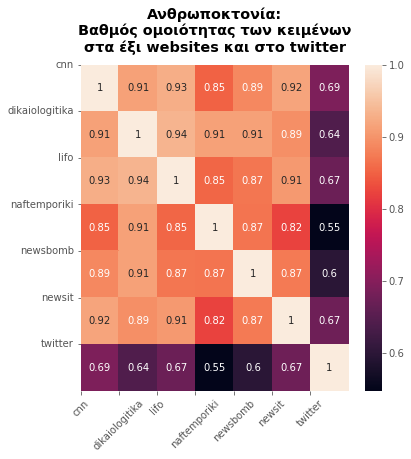

In [ ]:
#import seaborn as sns
plt.figure(figsize=(6, 6))
# annot = True to print the values inside the square
plt.title('Ανθρωποκτονία:\nΒαθμός ομοιότητας των κειμένων\nστα έξι websites και στο twitter', y=1.02, fontweight='bold')
sns.heatmap(data=arr_homo, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=0)

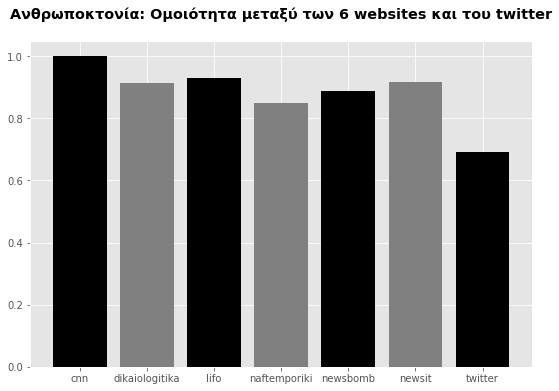

In [ ]:
xs = pd.DataFrame(arr_homo).columns
ys = pd.DataFrame(arr_homo).loc[0].head(8)
labels = ['cnn','dikaiologitika','lifo', 'naftemporiki', 'newsbomb', 'newsit', 'twitter']

plt.rcParams["figure.figsize"] = (9,6)

plt.bar(xs,ys, color=['black', 'gray'])
plt.title('Ανθρωποκτονία: Ομοιότητα μεταξύ των 6 websites και του twitter', y=1.05, fontweight='bold')
#plt.xlabel('πηγή κειμένων')

plt.xticks(xs,labels)#,rotation=45, ha='center')

# reset figure size
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

**Cosine similarity - suicide**

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo[0:1], tfidf_matrix_train_homo))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo, tfidf_matrix_train_homo))  #here all the element of tfidf_matrix_train are matched with all other elements
arr_sui = cosine_similarity(tfidf_matrix_train_sui, tfidf_matrix_train_sui)

([<matplotlib.axis.YTick at 0x7f83caf2f650>,
 [Text(0, 0.5, 'cnn'),
  Text(0, 1.5, 'dikaiologitika'),
  Text(0, 2.5, 'lifo'),
  Text(0, 3.5, 'naftemporiki'),
  Text(0, 4.5, 'newsbomb'),
  Text(0, 5.5, 'newsit'),
  Text(0, 6.5, 'twitter')])

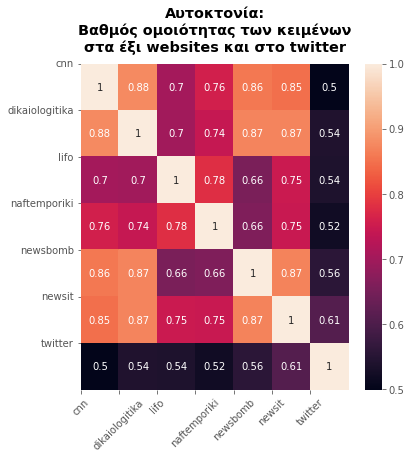

In [ ]:
#import seaborn as sns
plt.figure(figsize=(6, 6))
# annot = True to print the values inside the square
plt.title('Αυτοκτονία:\nΒαθμός ομοιότητας των κειμένων\nστα έξι websites και στο twitter', y=1.02, fontweight='bold')
sns.heatmap(data=arr_sui, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=0)

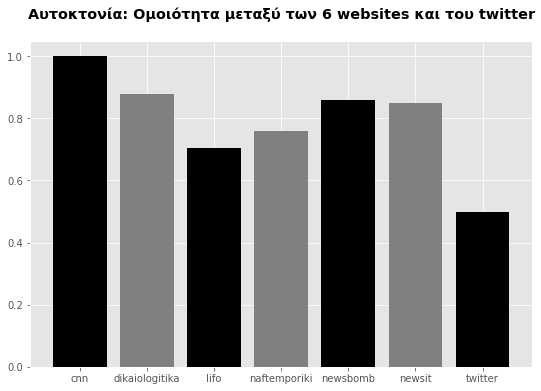

In [ ]:
xs = pd.DataFrame(arr_sui).columns
ys = pd.DataFrame(arr_sui).loc[0].head(8)
labels = ['cnn','dikaiologitika','lifo', 'naftemporiki', 'newsbomb', 'newsit', 'twitter']

plt.rcParams["figure.figsize"] = (9,6)

plt.bar(xs,ys, color=['black', 'gray'])
plt.title('Αυτοκτονία: Ομοιότητα μεταξύ των 6 websites και του twitter', y=1.05, fontweight='bold')
#plt.xlabel('πηγή κειμένων')

plt.xticks(xs,labels)#,rotation=45, ha='center')

# reset figure size
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

**Cosine similarity - ergatiko**

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo[0:1], tfidf_matrix_train_homo))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo, tfidf_matrix_train_homo))  #here all the element of tfidf_matrix_train are matched with all other elements
arr_erg = cosine_similarity(tfidf_matrix_train_erg, tfidf_matrix_train_erg)

([<matplotlib.axis.YTick at 0x7f83d246efd0>,
 [Text(0, 0.5, 'cnn'),
  Text(0, 1.5, 'dikaiologitika'),
  Text(0, 2.5, 'lifo'),
  Text(0, 3.5, 'naftemporiki'),
  Text(0, 4.5, 'newsbomb'),
  Text(0, 5.5, 'newsit'),
  Text(0, 6.5, 'twitter')])

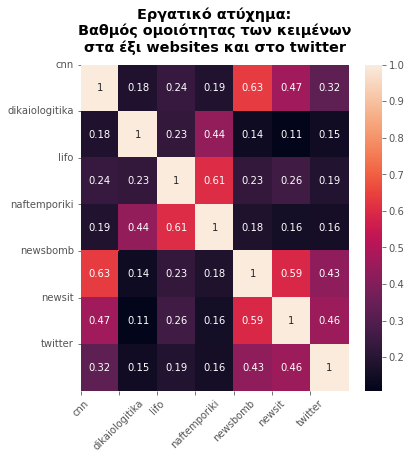

In [ ]:
#import seaborn as sns
plt.figure(figsize=(6, 6))
# annot = True to print the values inside the square
plt.title('Εργατικό ατύχημα:\nΒαθμός ομοιότητας των κειμένων\nστα έξι websites και στο twitter', y=1.02, fontweight='bold')
sns.heatmap(data=arr_erg, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=0)

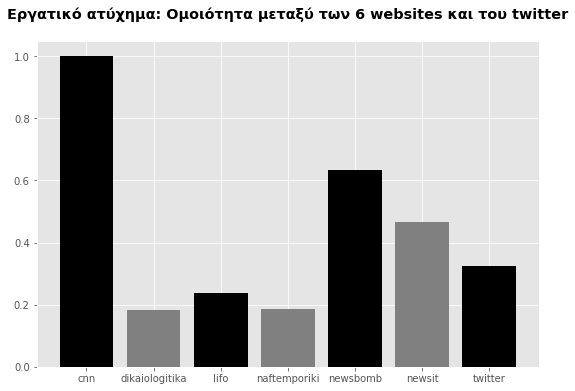

In [ ]:
xs = pd.DataFrame(arr_erg).columns
ys = pd.DataFrame(arr_erg).loc[0].head(8)
labels = ['cnn','dikaiologitika','lifo', 'naftemporiki', 'newsbomb', 'newsit', 'twitter']

plt.rcParams["figure.figsize"] = (9,6)

plt.bar(xs,ys, color=['black', 'gray'])
plt.title('Εργατικό ατύχημα: Ομοιότητα μεταξύ των 6 websites και του twitter', y=1.05, fontweight='bold')
#plt.xlabel('πηγή κειμένων')

plt.xticks(xs,labels)#,rotation=45, ha='center')

# reset figure size
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

**Cosine similarity - troxaio**

In [ ]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo[0:1], tfidf_matrix_train_homo))  #here the first element of tfidf_matrix_train is matched with other seven elements
#print("cosine scores ==> ",cosine_similarity(tfidf_matrix_train_homo, tfidf_matrix_train_homo))  #here all the element of tfidf_matrix_train are matched with all other elements
arr_tro = cosine_similarity(tfidf_matrix_train_tro, tfidf_matrix_train_tro)

([<matplotlib.axis.YTick at 0x7f83cf8c79d0>,
 [Text(0, 0.5, 'cnn'),
  Text(0, 1.5, 'dikaiologitika'),
  Text(0, 2.5, 'lifo'),
  Text(0, 3.5, 'naftemporiki'),
  Text(0, 4.5, 'newsbomb'),
  Text(0, 5.5, 'newsit'),
  Text(0, 6.5, 'twitter')])

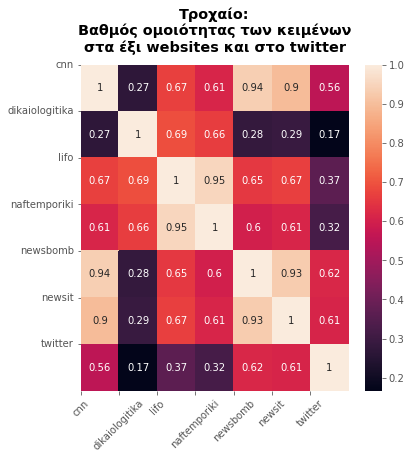

In [ ]:
#import seaborn as sns
plt.figure(figsize=(6, 6))
# annot = True to print the values inside the square
plt.title('Τροχαίο:\nΒαθμός ομοιότητας των κειμένων\nστα έξι websites και στο twitter', y=1.02, fontweight='bold')
sns.heatmap(data=arr_tro, annot=True)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['cnn','dikaiologitika','lifo','naftemporiki','newsbomb','newsit','twitter'], rotation=0)

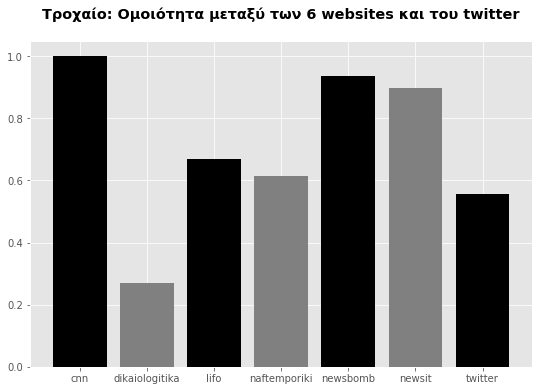

In [ ]:
xs = pd.DataFrame(arr_tro).columns
ys = pd.DataFrame(arr_tro).loc[0].head(8)
labels = ['cnn','dikaiologitika','lifo', 'naftemporiki', 'newsbomb', 'newsit', 'twitter']

plt.rcParams["figure.figsize"] = (9,6)

plt.bar(xs,ys, color=['black', 'gray'])
plt.title('Τροχαίο: Ομοιότητα μεταξύ των 6 websites και του twitter', y=1.05, fontweight='bold')
#plt.xlabel('πηγή κειμένων')

plt.xticks(xs,labels)#,rotation=45, ha='center')

# reset figure size
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

###**11 ---- Sentiment analysis**

In [ ]:
# read emolex file
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)

# drop duplicates and NaNs
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(drop=True, inplace = True)

# transform to lower
emolex_df['word'] = emolex_df['word'].str.lower()

emolex_df.head(1)

word  Positive  Negative  Anger  Anticipation  Disgust  Fear  Joy  \
0  αφεση       1.0       0.0    0.0           0.0      0.0   0.0  0.0   

   Sadness  Surprise  Trust  
0      0.0       0.0    0.0

In [ ]:
emolex_df['word'] = emolex_df['word'].str.lower()

In [ ]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= gr_stopwords,
                      ngram_range=(1, 2))

**Find emolex words in tweets corpora - websites**

In [ ]:
matrix = vec.fit_transform(comp_df['clean_text']) #[comp_df.source != "twitter"]
vocab = vec.get_feature_names_out()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε', 

In [ ]:
wordcount_df.shape

(10516, 13161)

**Create lists with polarized emolex words** 

In [ ]:
emolex_df.columns

Index(['word', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
       'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'],
      dtype='object')

In [ ]:
# Φτιάξε μια λίστα με positive words
positive_words = emolex_df[emolex_df.Positive == 1]['word']

# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']

# Φτιάξε μια λίστα με anger words
angry_words = emolex_df[emolex_df.Anger == 1]['word']

# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']

# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']

# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']

**Create columns with sentiment scores**

In [ ]:
comp_df['positivity'] = wordcount_df[positive_words].sum(axis=1)
comp_df['negativity'] = wordcount_df[negative_words].sum(axis=1)

comp_df['anger'] = wordcount_df[angry_words].sum(axis=1)
comp_df['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
comp_df['disgust'] = wordcount_df[disgust_words].sum(axis=1)
comp_df['fear'] = wordcount_df[fear_words].sum(axis=1)
comp_df['joy'] = wordcount_df[joy_words].sum(axis=1)
comp_df['sadness'] = wordcount_df[sadness_words].sum(axis=1)
comp_df['surprise'] = wordcount_df[surprise_words].sum(axis=1)
comp_df['trust'] = wordcount_df[trust_words].sum(axis=1)

In [ ]:
comp_df.columns

Index(['datetime', 'topic', 'source', 'sub_topic', 'full_text', 'clean_text',
       'clean_text_new', 'positivity', 'negativity', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [ ]:
comp_df.loc[:, ['datetime', 'topic', 'source', 'positivity',
       'negativity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust']]

datetime     topic    source  positivity  negativity  anger  \
0      2020-01-01 00:32:59  homocide   twitter        11.0         7.0    2.0   
1      2020-01-01 01:04:06   troxaio   twitter        10.0        20.0   11.0   
2      2020-01-01 01:23:01  homocide   twitter         0.0         3.0    2.0   
3      2020-01-01 02:34:59   troxaio   twitter        13.0        24.0   15.0   
4      2020-01-01 02:43:23   troxaio   twitter         0.0         3.0    2.0   
...                    ...       ...       ...         ...         ...    ...   
112118 2020-12-31 15:11:00  homocide      lifo         NaN         NaN    NaN   
112119 2020-12-31 17:57:00   troxaio  newsbomb         NaN         NaN    NaN   
112120 2020-12-31 18:31:00  homocide      lifo         NaN         NaN    NaN   
112121 2020-12-31 19:54:00   troxaio  newsbomb         NaN         NaN    NaN   
112122 2020-12-31 22:22:05   troxaio    newsit         NaN         NaN    NaN   

        anticipation  disgust  fear  joy  sadness  surprise  trust  
0                5.0      1.0   5.0  4.0      3.0       3.0    8.0  
1                5.0      8.0  12.0  3.0     14.0       3.0    5.0  
2                1.0      0.0   3.0  0.0      3.0       0.0    0.0  
3               13.0     12.0  14.0  3.0     13.0       7.0   25.0  
4                1.0      1.0   3.0  0.0      3.0       1.0    0.0  
...              ...      ...   ...  ...      ...       ...    ...  
112118           NaN      NaN   NaN  NaN      NaN       NaN    NaN  
112119           NaN      NaN   NaN  NaN      NaN       NaN    NaN  
112120           NaN      NaN   NaN  NaN      NaN       NaN    NaN  
112121           NaN      NaN   NaN  NaN      NaN       NaN    NaN  
112122           NaN      NaN   NaN  NaN      NaN       NaN    NaN  

[112123 rows x 13 columns]

**Play with time to make timeseries graphs**

In [ ]:
# create datehours (keep hours, put zeros to minutes and seconds)
comp_df['datehours'] = comp_df['datetime'].astype('datetime64[h]')

In [ ]:
# What is the start and end date of the time series data set we are working with?
comp_df["datehours"].min(), comp_df["datehours"].max()

(Timestamp('2022-06-08 14:00:00'), Timestamp('2022-06-11 10:00:00'))

In [ ]:
# What is the length of our time series?
comp_df["datehours"].max() - comp_df["datehours"].min()

Timedelta('2 days 20:00:00')

In [ ]:
# What is the length of time series for Greek tweets?
comp_df[comp_df.name == 'gr_tweet']["datehours"].max() - comp_df[comp_df.name == 'gr_tweet']["datehours"].min()

Timedelta('2 days 20:00:00')

In [ ]:
# What is the length of time series for Turkish tweets?
comp_df[comp_df.name == 'tr_tweet']["datehours"].max() - comp_df[comp_df.name == 'tr_tweet']["datehours"].min()

Timedelta('0 days 16:00:00')

In [ ]:
# What is the start and end date of the time series data for the greek tweets?
comp_df[comp_df.name == 'gr_tweet']["datehours"].min(), comp_df[comp_df.name == 'gr_tweet']["datehours"].max()

(Timestamp('2022-06-08 14:00:00'), Timestamp('2022-06-11 10:00:00'))

In [ ]:
# What is the start and end date of the time series data for the turkish tweets?
comp_df[comp_df.name == 'tr_tweet']["datehours"].min(), comp_df[comp_df.name == 'tr_tweet']["datehours"].max()

(Timestamp('2022-06-10 18:00:00'), Timestamp('2022-06-11 10:00:00'))

In [ ]:
# create a df for turkish tweets from comp_df, with all datetimes and fill the greek rows with NaN
turkish_all_dates_df = comp_df.copy()
turkish_all_dates_df[['full_text', 'clean_text', 'gr_text',
       'translated_text', 'clean_translated_text', 'text', 'positivity',
       'negativity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust']] = comp_df[['full_text', 'clean_text', 'gr_text',
       'translated_text', 'clean_translated_text', 'text', 'positivity',
       'negativity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust']].mask(comp_df['name'] == 'gr_tweet', np.nan)

# Bring in datetime, name and datehours
turkish_all_dates_df[['datetime', 'name', 'datehours']] = comp_df[['datetime', 'name', 'datehours']]

In [ ]:
# create a df for greek tweets from comp_df, with all datetimes and fill the greek rows with NaN
greek_all_dates_df = comp_df.copy()
greek_all_dates_df[['full_text', 'clean_text', 'gr_text',
       'translated_text', 'clean_translated_text', 'text', 'positivity',
       'negativity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust']] = comp_df[['full_text', 'clean_text', 'gr_text',
       'translated_text', 'clean_translated_text', 'text', 'positivity',
       'negativity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust']].mask(comp_df['name'] == 'tr_tweet', np.nan)

# Bring in datetime, name and datehours
greek_all_dates_df[['datetime', 'name', 'datehours']] = comp_df[['datetime', 'name', 'datehours']]

**Tweets sent per hour**

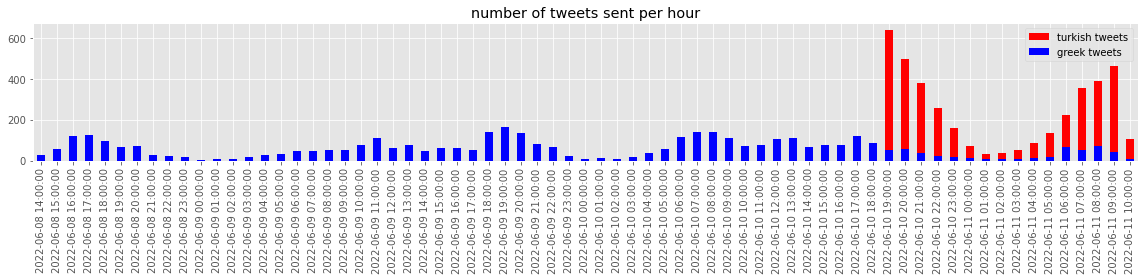

In [ ]:
# tweets sent per hour
fig = plt.figure()
ax = turkish_all_dates_df.groupby('datehours')['text'].count().plot(kind='bar', figsize=(16,8), color = 'red', label='turkish tweets', xlabel = '')
greek_all_dates_df.groupby('datehours')['text'].count().plot(kind='bar', figsize=(16,4), ax = ax, color = 'blue', label='greek tweets', xlabel = '', title = "number of tweets sent per hour").legend()
plt.tight_layout()
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/number-of-tweets-per-hour.png')

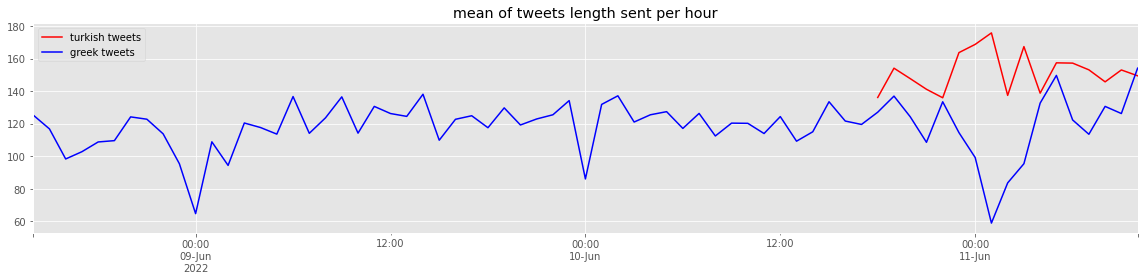

In [ ]:
# mean of tweets' length sent per hour
fig = plt.figure()
ax = turkish_all_dates_df['text'].str.len().groupby(by=greek_all_dates_df['datehours']).mean().plot(figsize=(16,4), color = 'red', label='turkish tweets', xlabel = '')
greek_all_dates_df['text'].str.len().groupby(by=greek_all_dates_df['datehours']).mean().plot(figsize=(16,4), ax=ax, color = 'blue', label='greek tweets', xlabel = '', title = "mean of tweets length sent per hour").legend() 
plt.tight_layout()
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/mean-of-tweets-length-sent-per-hour.png')

**Time series graphs**

In [ ]:
# separate greek tweets
greek_df = comp_df[comp_df.name == 'gr_tweet']
# set datehours as index
greek_df.set_index('datehours', inplace =True)

In [ ]:
# separate turkish tweets
turkish_df = comp_df[comp_df.name == 'tr_tweet']
# set datehours as index
turkish_df.set_index('datehours', inplace =True)

Positivity Vs Negativity

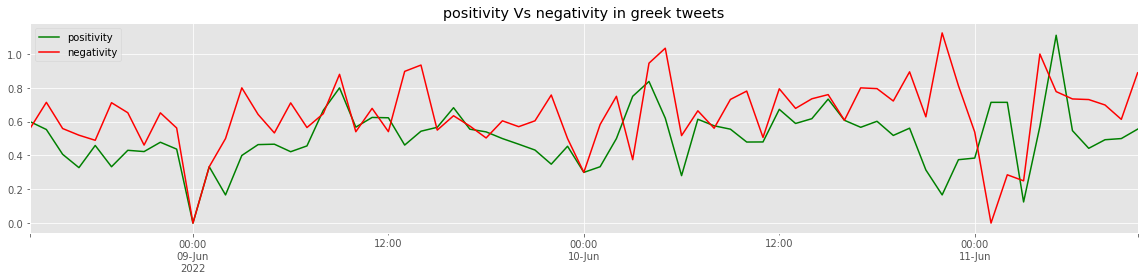

In [ ]:
# positivity and negativity in greek tweets
#fig=plt.figure()
ax = greek_df[['positivity', 'negativity']].resample('H').mean().plot(figsize=(16,4), color = ['green', 'red'], xlabel='', title = "positivity Vs negativity in greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/positivity-vs-negativity-in-greek-tweets.png')

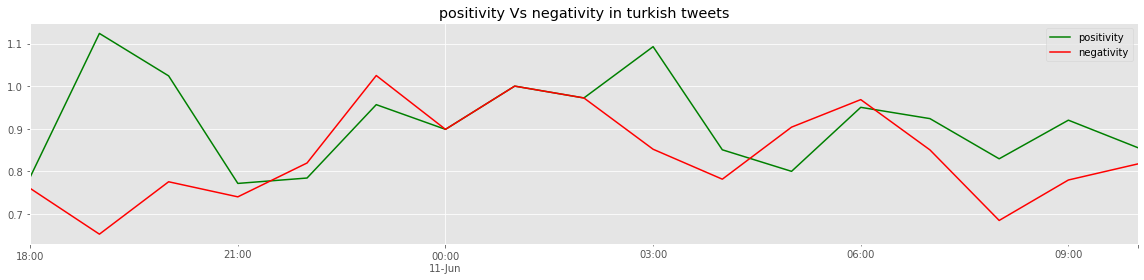

In [ ]:
# positivity and negativity in turkish tweets
#fig=plt.figure()
ax = turkish_df[['positivity', 'negativity']].resample('H').mean().plot(figsize=(16,4), color = ['green', 'red'], xlabel='', title = "positivity Vs negativity in turkish tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/positivity-vs-negativity-in-turkish-tweets.png')

Anger, fear, joy, sadness and trust

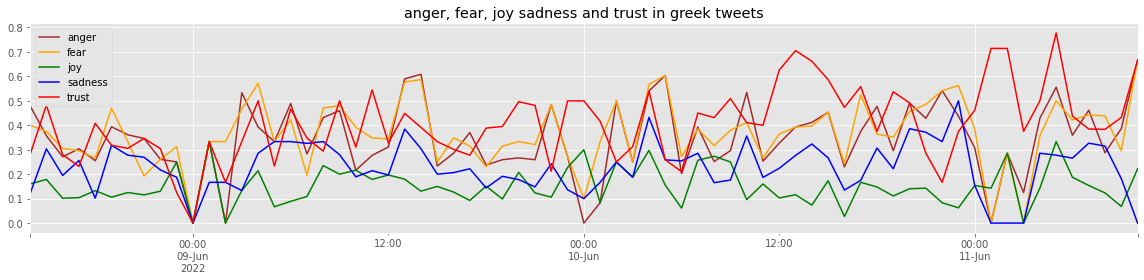

In [ ]:
# anger, fear, joy, sadness and trust in greek tweets
#fig=plt.figure()
ax = greek_df[['anger', 'fear', 'joy', 'sadness', 'trust']].resample('H').mean().plot(figsize=(16,4), color = ['brown', 'orange', 'green', 'blue', 'red'], xlabel='', title = "anger, fear, joy sadness and trust in greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/anger-fear-joy-sadness-trust-in-turkish-tweets.png')

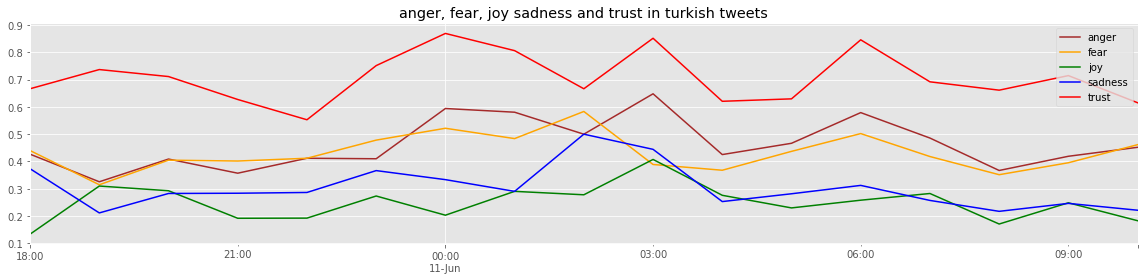

In [ ]:
# anger, fear, joy, sadness and trust in greek tweets
#fig=plt.figure()
ax = turkish_df[['anger', 'fear', 'joy', 'sadness', 'trust']].resample('H').mean().plot(figsize=(16,4), color = ['brown', 'orange', 'green', 'blue', 'red'], xlabel='', title = "anger, fear, joy sadness and trust in turkish tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/anger-fear-joy-sadness-trust-in-turkish-tweets.png')

Comparisons

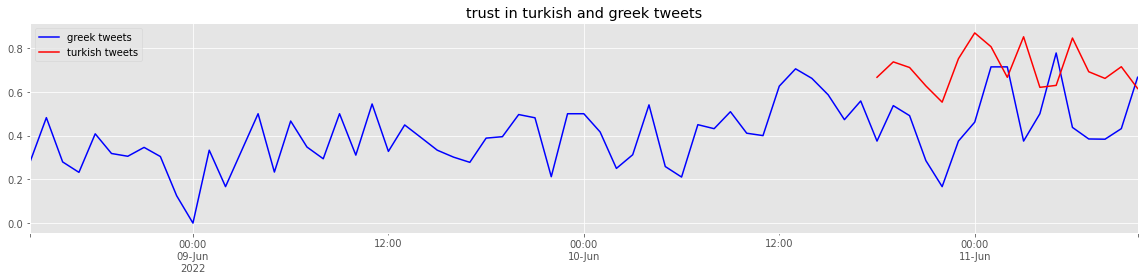

In [ ]:
# Trust: comparison between greek and turkish tweets 
fig = plt.figure()
ax = greek_df['trust'].resample('H').mean().plot(figsize=(16,4), color = 'blue', label='greek tweets', xlabel='')
turkish_df['trust'].resample('H').mean().plot(figsize=(16,4), ax = ax, color = 'red', label='turkish tweets', xlabel='', title = "trust in turkish and greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/trust-greek-turkish.png')

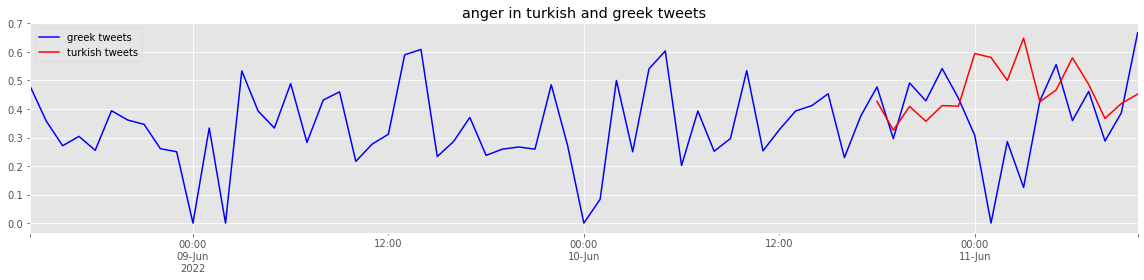

In [ ]:
# anger: greek_tweets Vs turkish_tweets
fig = plt.figure()
ax = greek_df['anger'].resample('H').mean().plot(figsize=(16,4), color = 'blue', label='greek tweets', xlabel='')
turkish_df['anger'].resample('H').mean().plot(figsize=(16,4), ax = ax, color = 'red', label='turkish tweets', xlabel='', title = "anger in turkish and greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/anger-greek-turkish.png')

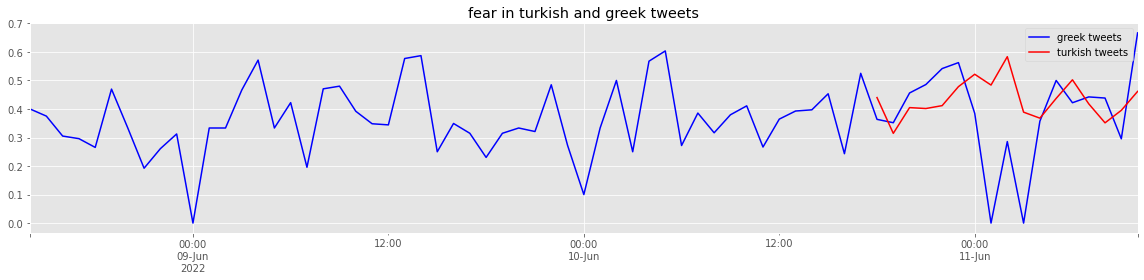

In [ ]:
# fear: greek_tweets Vs turkish_tweets
fig = plt.figure()
ax = greek_df['fear'].resample('H').mean().plot(figsize=(16,4), color = 'blue', label='greek tweets', xlabel='')
turkish_df['fear'].resample('H').mean().plot(figsize=(16,4), ax = ax, color = 'red', label='turkish tweets', xlabel='', title = "fear in turkish and greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/fear-greek-turkish.png')

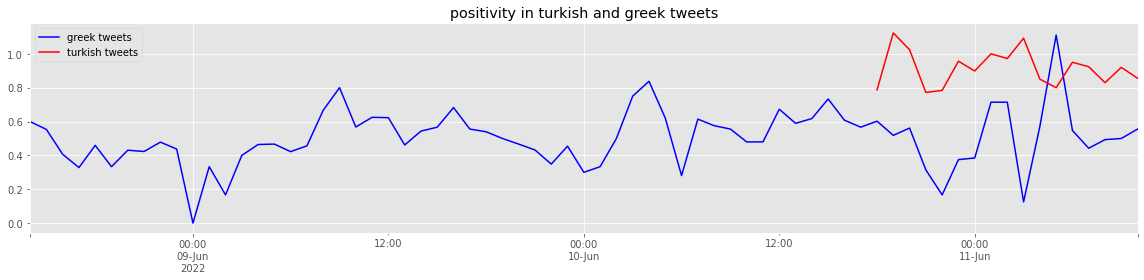

In [ ]:
# Positivity: greek_tweets Vs turkish_tweets
fig = plt.figure()
ax = greek_df['positivity'].resample('H').mean().plot(figsize=(16,4), color = 'blue', label='greek tweets', xlabel='')
turkish_df['positivity'].resample('H').mean().plot(figsize=(16,4), ax = ax, color = 'red', label='turkish tweets', xlabel='', title = "positivity in turkish and greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/positivity-greek-turkish.png')

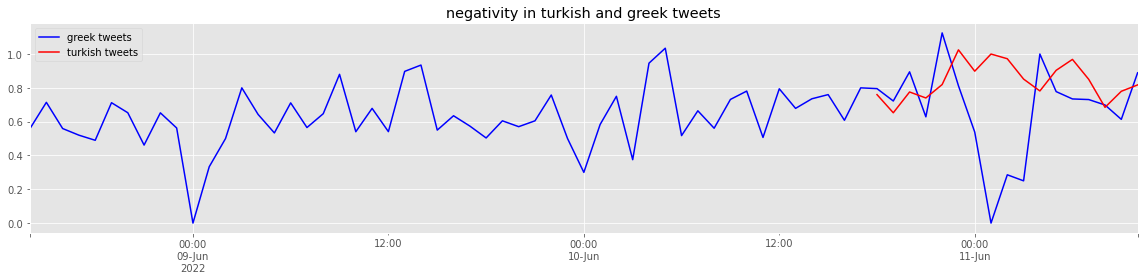

In [ ]:
# Negativity: greek_tweets Vs turkish_tweets
fig = plt.figure()
ax = greek_df['negativity'].resample('H').mean().plot(figsize=(16,4), color = 'blue', label='greek tweets', xlabel='')
turkish_df['negativity'].resample('H').mean().plot(figsize=(16,4), ax = ax, color = 'red', label='turkish tweets', xlabel='', title = "negativity in turkish and greek tweets").legend()
plt.tight_layout()
#fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/Scraping/Tweets/Images-Masks/negativity-greek-turkish.png')